In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from tools.cbook import pickle2Obj
from analysis_tools import check_data
import pickle

plot_attr   = { 
                "mpas":  {"name":"MPAS-4TH",      "color": 'r',   'linewidth': 2.0, 'linestyle': 'solid'},
                "mpas3": {"name":"MPAS-3RD",  "color": 'r',   'linewidth': 1.0, 'linestyle': 'solid'},
                "cm1":   {"name":"CM1-5TH",       "color": 'b',   'linewidth': 2.0, 'linestyle': 'solid'},
                "cm1-4": {"name":"CM1-4TH",   "color": 'b',   'linewidth': 1.0, 'linestyle': 'solid'},
                "wrf":   {"name":"WRF-5TH",       "color": 'k',   'linewidth': 2.0, 'linestyle': 'solid'},
                "wrf-4": {"name":"WRF-4TH",   "color": 'k',   'linewidth': 1.0, 'linestyle': 'solid'},
               }

# plot_attr['mpas']   |= {'C2000_18': {'linestyle': '--'}, 'C3500_18': {'linestyle': '--'}}
# plot_attr['mpas3'] |= {'C2000_18': {'linestyle': '--'}, 'C3500_18': {'linestyle': '--'}}
# plot_attr['cm1']    |= {'C2000_18': {'linestyle': '--'}, 'C3500_18': {'linestyle': '--'}}
# plot_attr['wrf']    |= {'C2000_18': {'linestyle': '--'}, 'C3500_18': {'linestyle': '--'}}

def get_plot_attr(model_key, p_attr, run_label=False):
    
    alist = ['name', 'linewidth', 'linestyle', 'color']
    
    attrs = []
    
    for item in alist:
        try:
            attrs.append(p_attr[model_key][item])
        except:
            break
        
    if run_label:
        for n, item in enumerate(alist):
            try:
                if item in p_attr[model_key][run_label]:
                    attrs[n] = p_attr[model_key][run_label][item]
            except KeyError:
                break
                     
    return attrs


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#--------------------------------------------------------------------------------------------
def plot_profile(profile, var, zhgts, ax, color, mlabel, step=None, percentile=None, median=None, 
                 linewidth=2.0, linestyle='solid'):

    label = "%s NOBJ:  %d" % (mlabel, profile[var].shape[1])
    
    p = profile[var]                     # extract the variable from the dataset.
        
    if step != None:
        t0 = profile['tindex'][step[0]]  # tells you the lookup index that corresponds to the time of objects.
        t1 = profile['tindex'][step[1]]
        p = p[:,t0:t1]                   # this gives you set of profiles for the given time block.
                    
    if percentile != None:
        psort = np.sort(p)               # sort profiles based on w in the profiles.
        idx   = int(percentile * psort.shape[1])
        if idx > 0 and idx < psort.shape[1]:
            p = psort[:,idx:]     # for percentile, average over from percentile on up.
        else:
            p = np.zeros_like(psort)
            
    if median != None:
        psort = np.sort(p)
        idx   = int(0.5 * psort.shape[1])
        if idx > 0 and idx < psort.shape[1]:
            p = psort[:,idx-1:idx+1]     # for median, average over 3 profiles.
        else:
            p = np.zeros_like(psort)
                                    
    if len(mlabel) < 2:
        label = "%s NOBJ:  %d" % (mlabel[0], p.shape[1])
    else:
        label = "%s-S%s (%d)" % (mlabel[0], mlabel[1], p.shape[1]) 
            
    ax.plot(p.mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label, linestyle=linestyle)
    
    return p.mean(axis=1).max()

#--------------------------------------------------------------------------------------------
# define plotting sub

def plot_profile_driver(models, variable = 'w', step = [1,-1], plabel = "", 
                        percentile=None, median=False, 
                        plotcape = ["C2000", "C3500"], plotshear=["06", "18"], 
                        xrange=None, yrange=[0.0,25.], zhgts = 0.25 + 0.25*np.arange(100),
                        figsize=(5,10), axes=None, my_plot_attr=None):
    
    imin = step[1]
    if imin < 0:
        imin = 24
    hour = float(imin)*15/60

    titles = ["0-%2.1f Hour Updraft Profiles" % hour]

    vmax_dict = {'w': [-2.0, 4.0, 8.0, 12., 16., 20.]}
            
    for m, cape in enumerate(plotcape):
        
        if axes == None:
            fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=figsize)
        else:
            ax = axes
        
        vmax = []
        
        for n, shear in enumerate(plotshear):
                               
            label = "%s_%s" % (cape, shear)
            
            for key in models:
                
                mdata = models[key][label]
                
                # check for specific styles for runs
                
                if my_plot_attr == None:  # use global values
                    name, linew, lines, color  = get_plot_attr(key, plot_attr, run_label=label)
                    
                else:
                    name, linew, lines, color  = get_plot_attr(key, my_plot_attr, run_label=label)
                
                if len(plotcape) > 1 or len(plotshear) > 1:
                    vmax.append(plot_profile(mdata, variable, zhgts, ax, color, [name, shear], step=step, linewidth=linew, linestyle=lines, percentile=percentile))

                else:
                    vmax.append(plot_profile(mdata, variable, zhgts, ax, color, [name], step=step, linewidth=linew, linestyle=lines, 
                                         percentile=percentile))

            if percentile == None and median == False:
                ax.set_title("%s" % (titles[0]), fontsize=14)
            if percentile != None and median == False:
                ax.set_title("(%d percentile) %s" % (int(percentile*100), titles[0]), fontsize=14)
            if median:  
                ax.set_title("(Median) %s" % (titles[0]), fontsize=14)

            ax.axhline(y=6., color='k', linestyle='-')
            ax.axhline(y=8., color='k', linestyle='-')
            ax.axhline(y=10., color='k', linestyle='-')
            ax.axvline(x=0.0, color='k', linestyle='--')
            ax.legend(fontsize=14, loc='upper right')

    # some fancy xrange stuff...
    
            if xrange != None:

                ax.set_xlim(xrange)

            else:
            
                vscal  = np.array(vmax_dict[variable])
                pmax   = max(vmax)
                xran  = vscal[vscal > pmax][0]
                ax.set_xlim(vscal[0],xran)

                for x in vmax_dict[variable]:
                    if x < pmax:
                        ax.axvline(x=x, color='k', linestyle='--', linewidth=0.5, alpha=0.25)

            ax.set_xlabel("%s" % variable.upper(), fontsize=16)
            ax.set_ylabel("Height(km)", fontsize=16)
            ax.set_ylim(0.0,15.)

            plt.suptitle("CAPE=%s  SHEAR=%s" % (cape[1:], shear), fontsize=16)

        if axes == None:
            if percentile == None and median == False:
                plt.savefig("WProfiles_%s_Experiment_%s.png" % (plabel,label))
            if percentile != None and median == False:
                plt.savefig("WProfiles_%d_percentile_%s_Experiment_%s.png" % (int(percentile*100), plabel,label))
            if median:
                plt.savefig("WProfiles_Median_%s_Experiment_%s.png" % (plabel,label))
    
            plt.show()

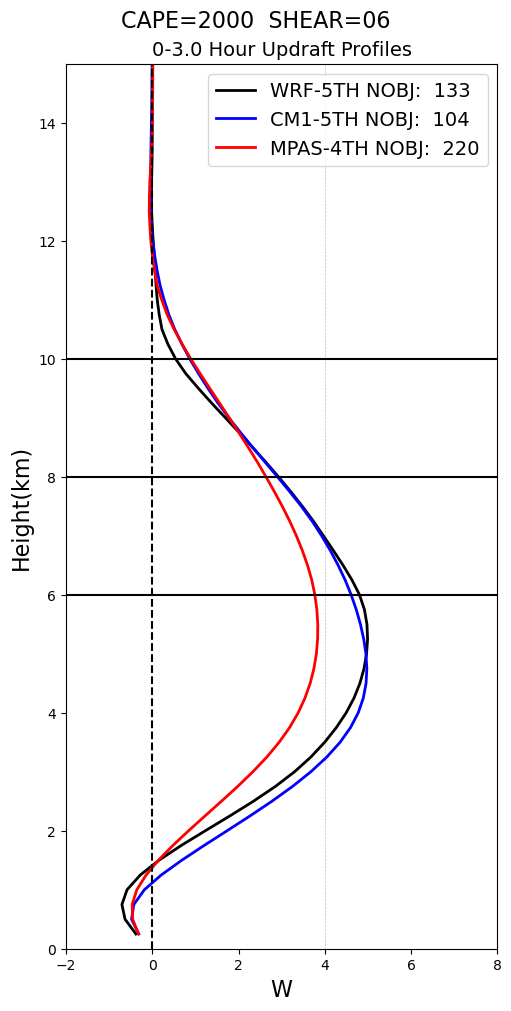

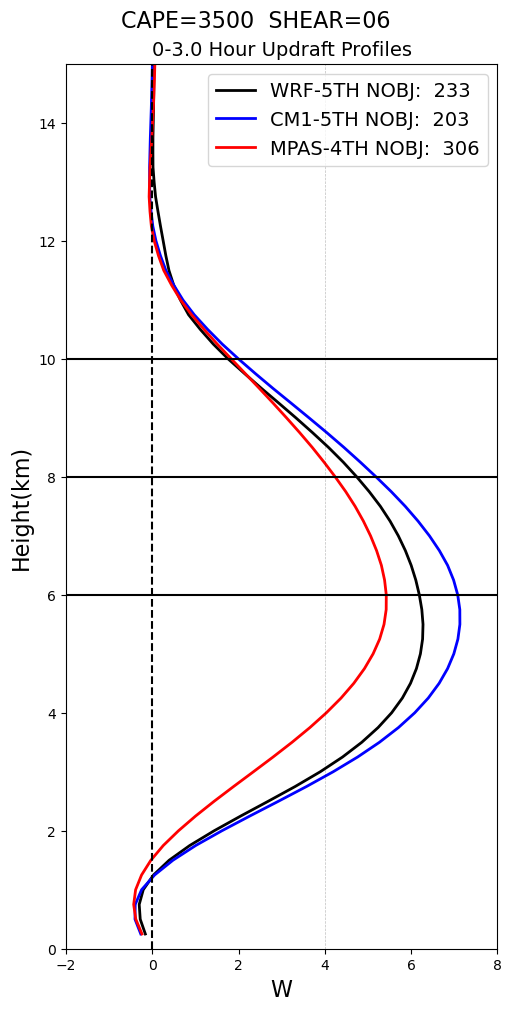

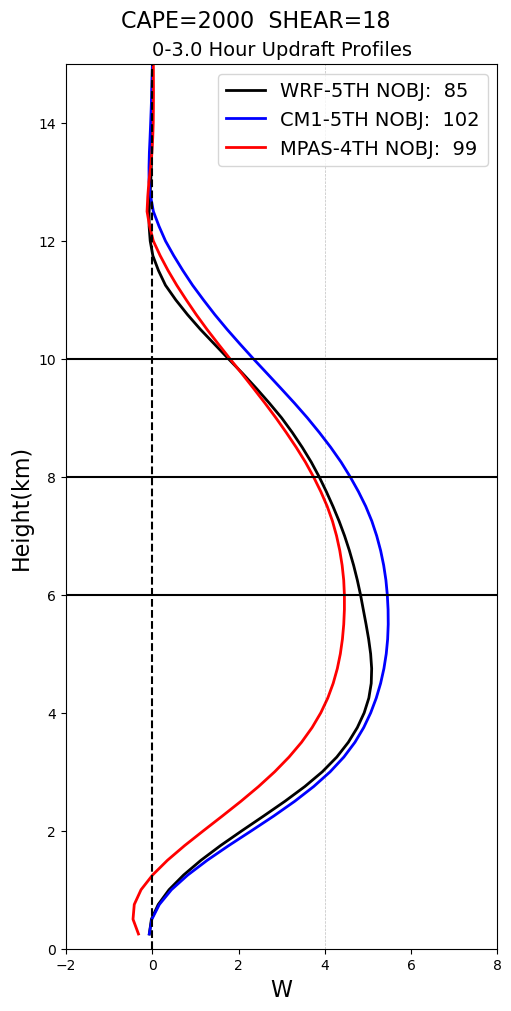

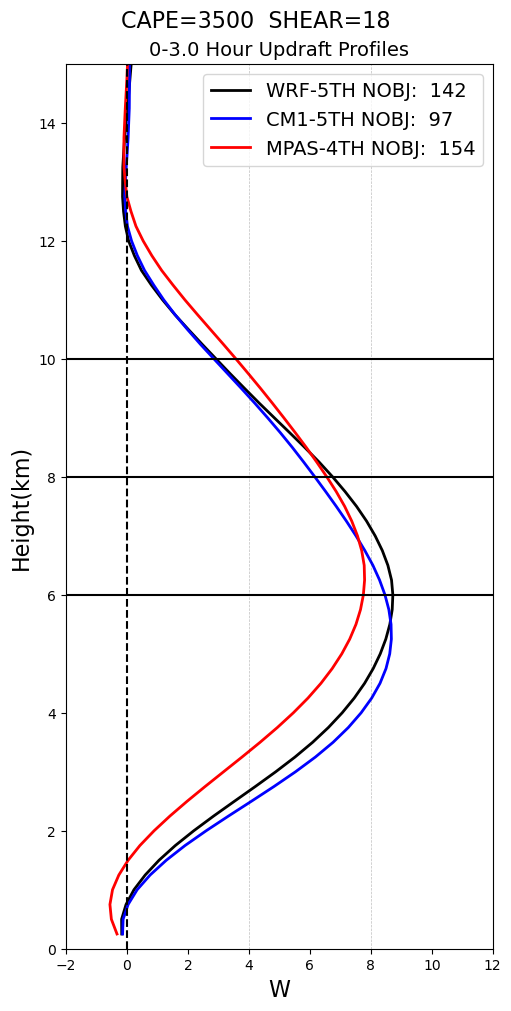

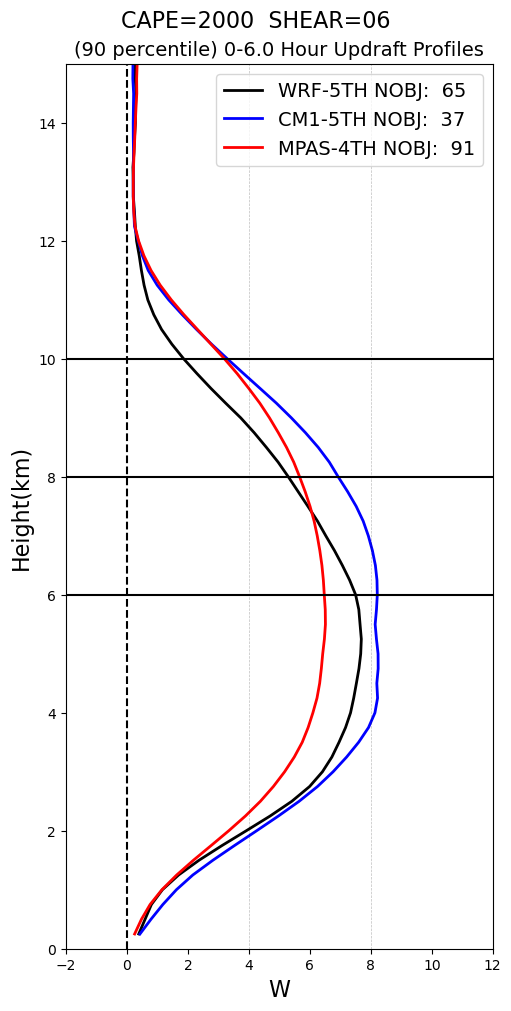

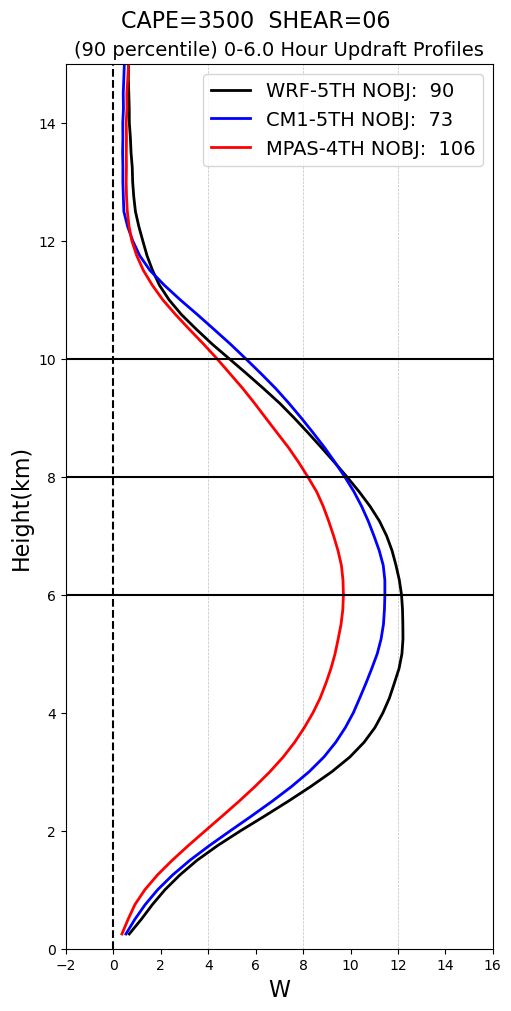

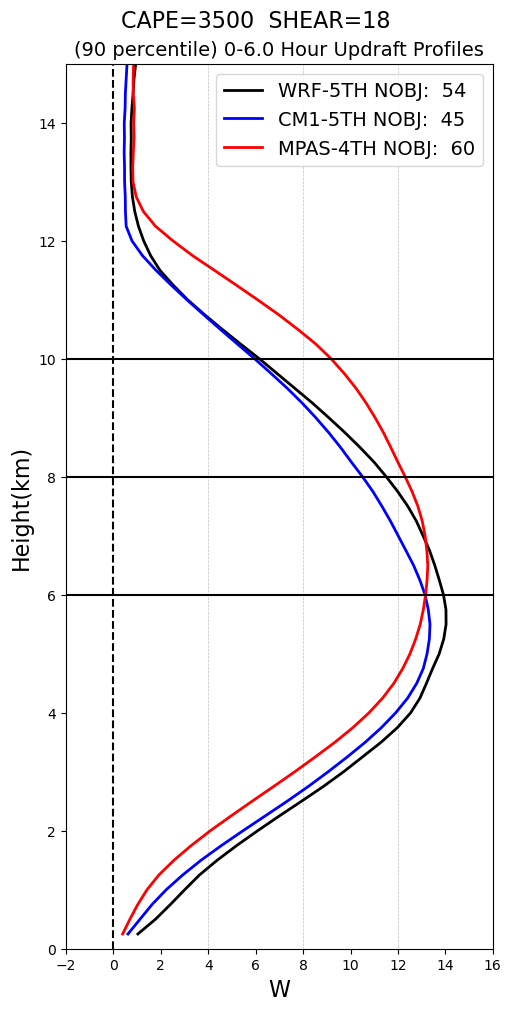

In [4]:
# Set profiles up

wrf_dir  = '/work/wicker/climate_runs/WRF_v4.4.2/ideal'
cm1_dir  = '/work/wicker/climate_runs/cm1r20.3/run/'
mpas_dir = '/work/wicker/climate_runs/MPAS/ideal/'

models = {}

models['wrf']      = pickle2Obj(os.path.join(wrf_dir, 'base/profile.pkl'),retObj=False)
models['cm1']      = pickle2Obj(os.path.join(cm1_dir, 'base/profile.pkl'),retObj=False)
models['mpas']     = pickle2Obj(os.path.join(mpas_dir, 'base/profile.pkl'),retObj=False)
models['mpas3']    = pickle2Obj(os.path.join(mpas_dir, 'vis01_3rd/profile.pkl'),retObj=False)


plot_profile_driver(models, plabel = 'Squall_3km', step = [0,12], plotcape=["C2000",], plotshear=["06"])
plot_profile_driver(models, plabel = 'Squall_3km', step = [0,12], plotcape=["C3500",], plotshear=["06"])


plot_profile_driver(models, plabel = 'Squall_3km', step = [0,12], plotcape=["C2000",], plotshear=["18"])
plot_profile_driver(models, plabel = 'Squall_3km', step = [0,12], plotcape=["C3500",], plotshear=["18"])

plot_profile_driver(models, plabel = 'Squall_3km', percentile=0.9, plotcape=["C2000",], plotshear=["06"])
plot_profile_driver(models, plabel = 'Squall_3km', percentile=0.9, plotcape=["C3500",], plotshear=["06"])
plot_profile_driver(models, plabel = 'Squall_3km', percentile=0.9, plotcape=["C3500",], plotshear=["18"])



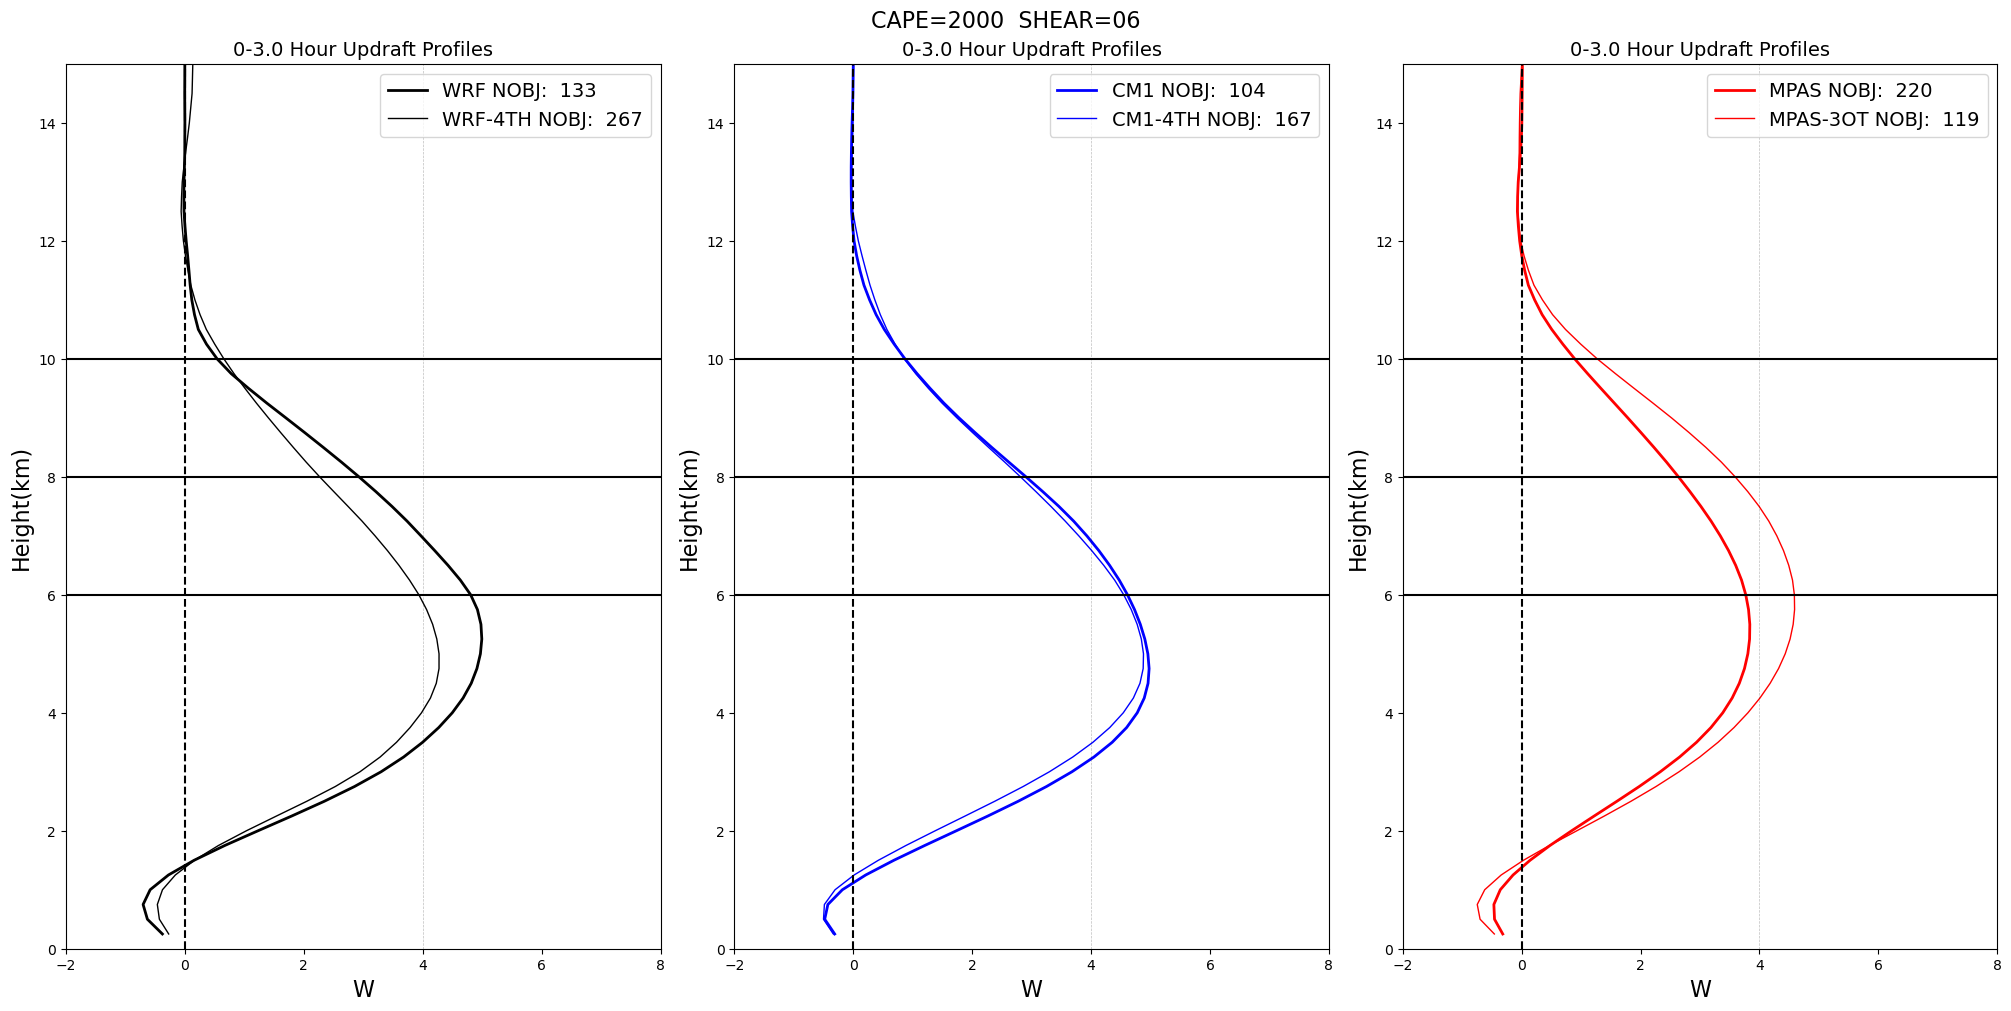

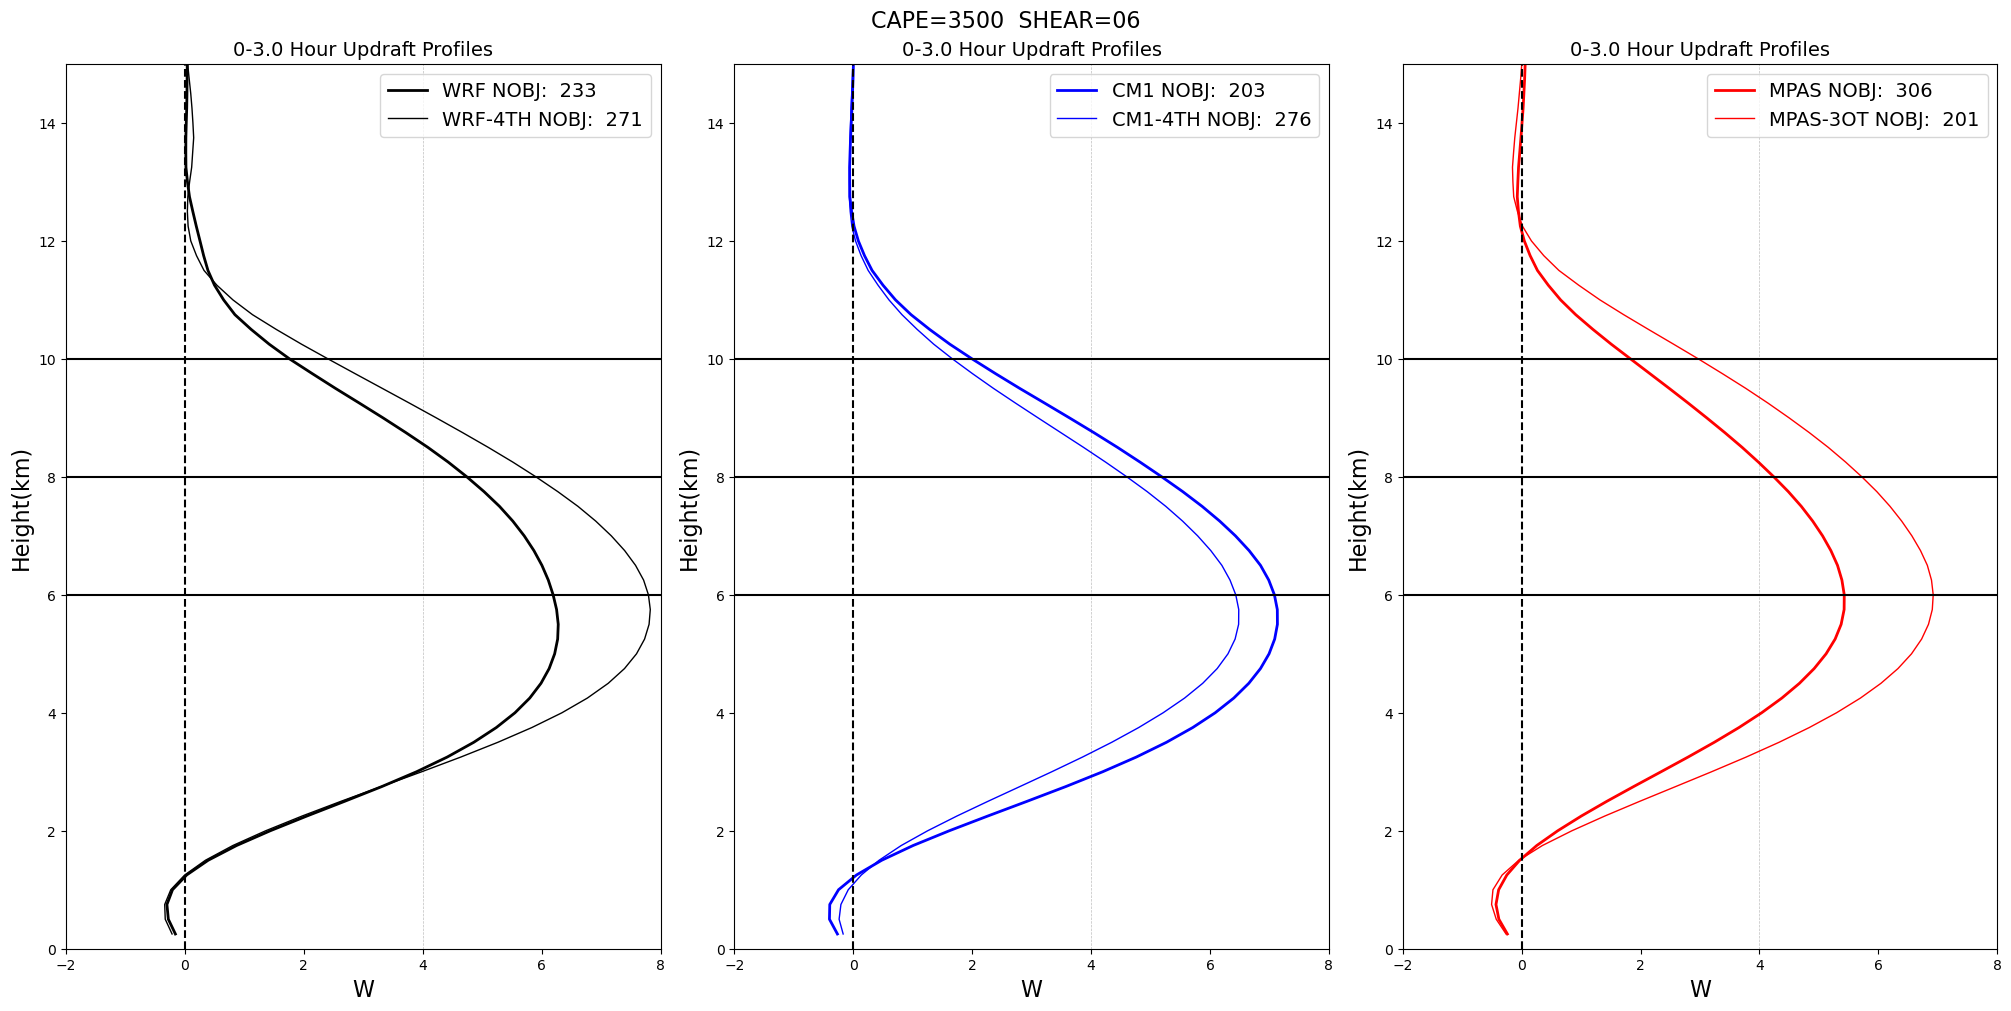

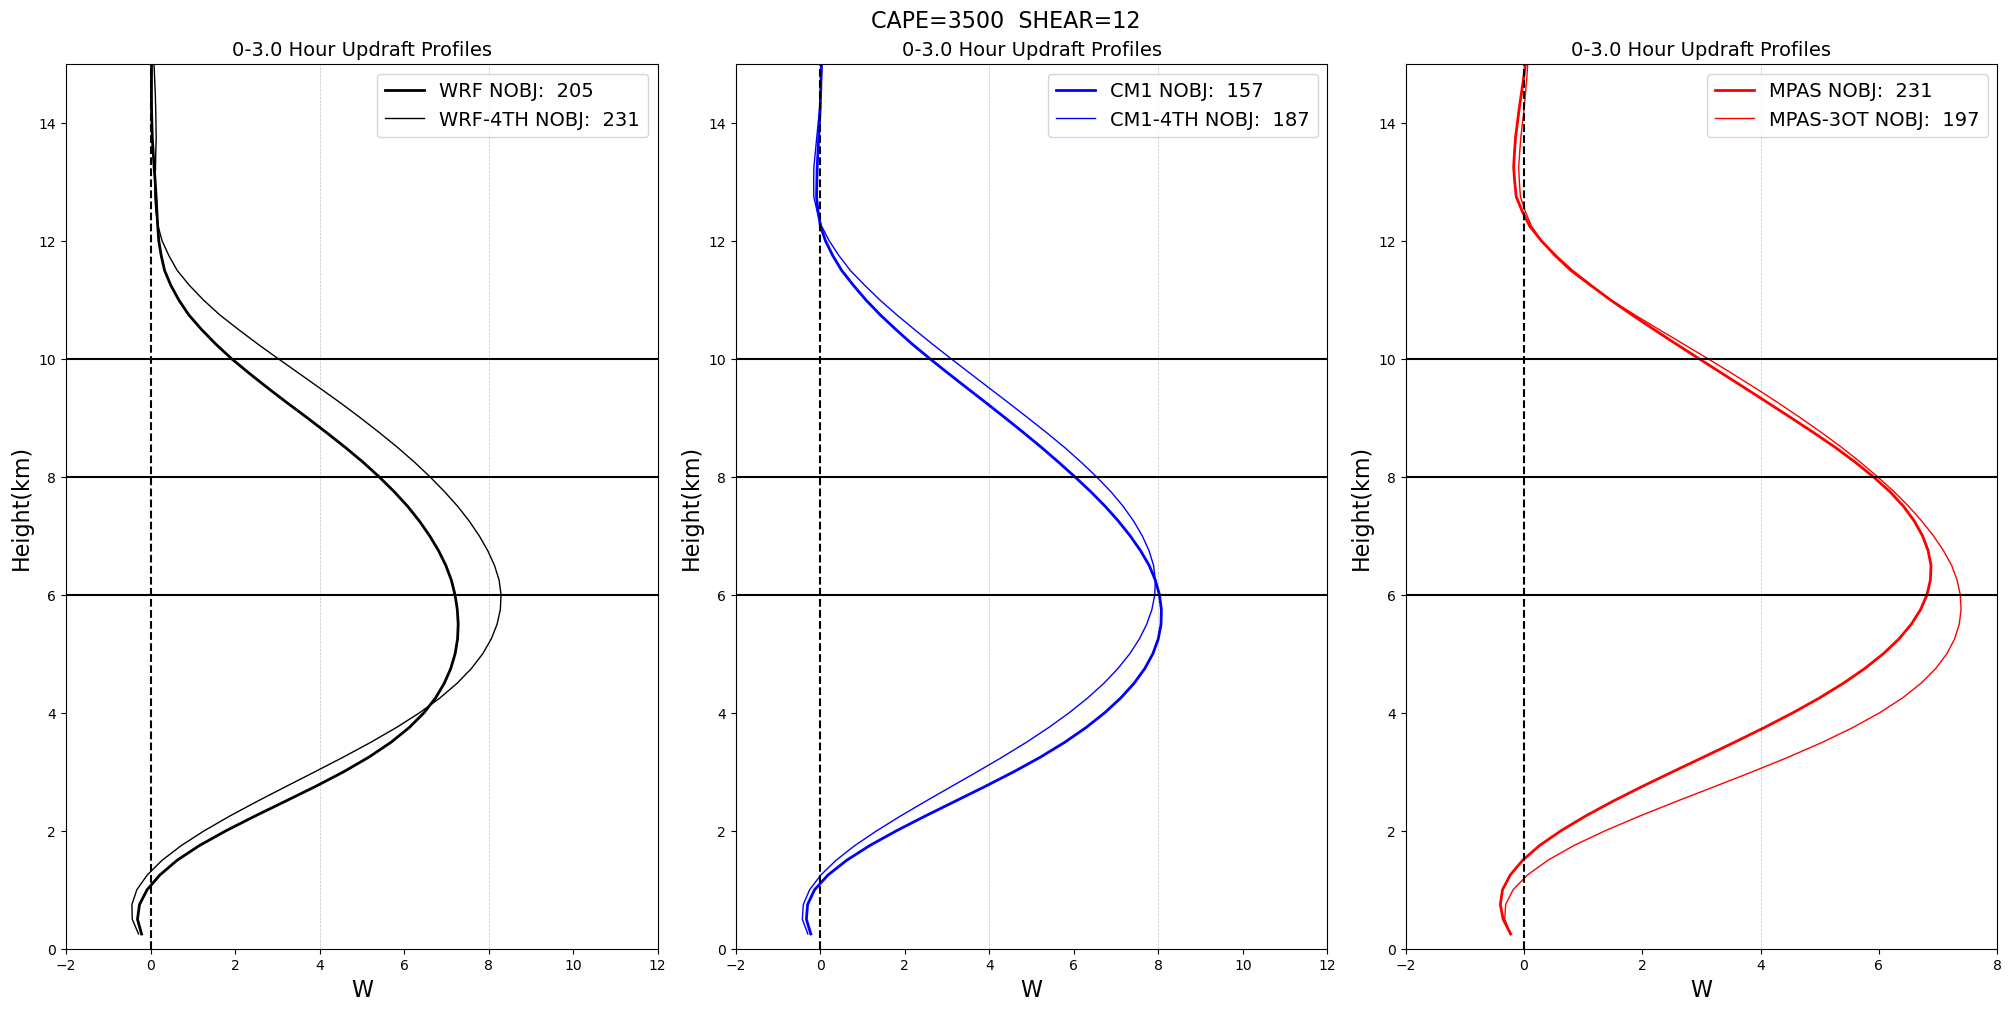

In [25]:
# Set profiles up

wrf_dir  = '/work/wicker/climate_runs/WRF_v4.4.2/ideal'
cm1_dir  = '/work/wicker/climate_runs/cm1r20.3/run/'
mpas_dir = '/work/wicker/climate_runs/MPAS/ideal/'

models1 = {}
models2 = {}
models3 = {}

models1['wrf']      = pickle2Obj(os.path.join(wrf_dir, 'base/profile.pkl'),retObj=False)
models1['wrf-4']    = pickle2Obj(os.path.join(wrf_dir, '4th/profile.pkl'),retObj=False)
models2['cm1']      = pickle2Obj(os.path.join(cm1_dir, 'base/profile.pkl'),retObj=False)
models2['cm1-4']    = pickle2Obj(os.path.join(cm1_dir, '4th/profile.pkl'),retObj=False)
models3['mpas']     = pickle2Obj(os.path.join(mpas_dir, 'base/profile.pkl'),retObj=False)
models3['mpas3']    = pickle2Obj(os.path.join(mpas_dir, 'vis01_3rd/profile.pkl'),retObj=False)

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))


plot_profile_driver(models1, axes=ax[0], plabel = 'Squall_3km',  step = [0,12], plotcape=["C2000",], plotshear=["06"])
plot_profile_driver(models2, axes=ax[1], plabel = 'Squall_3km', step = [0,12], plotcape=["C2000",], plotshear=["06"])
plot_profile_driver(models3, axes=ax[2], plabel = 'Squall_3km', step = [0,12], plotcape=["C2000",], plotshear=["06"])
plt.show()


##

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

plot_profile_driver(models1, axes=ax[0], plabel = 'Squall_3km',  step = [0,12], plotcape=["C3500",], plotshear=["06"])
plot_profile_driver(models2, axes=ax[1], plabel = 'Squall_3km', step = [0,12], plotcape=["C3500",], plotshear=["06"])
plot_profile_driver(models3, axes=ax[2], plabel = 'Squall_3km', step = [0,12], plotcape=["C3500",], plotshear=["06"])
plt.show()

#

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))

plot_profile_driver(models1, axes=ax[0], plabel = 'Squall_3km',  step = [0,12], plotcape=["C3500",], plotshear=["12"])
plot_profile_driver(models2, axes=ax[1], plabel = 'Squall_3km', step = [0,12], plotcape=["C3500",], plotshear=["12"])
plot_profile_driver(models3, axes=ax[2], plabel = 'Squall_3km', step = [0,12], plotcape=["C3500",], plotshear=["12"])
plt.show()


In [5]:
#----------------------------------------------------
def plot_cumulative_dist(models, step = [1,-1], plabel = "", plotcape = ["C2000", "C3500"], plotshear=["06", "18"], my_plot_attr=None):
    
    titles = ["0-6 Hour Updraft Sizes", "0-2 Hour Updraft Sizes", "2-4 Hour Updraft Sizes"]
    
    step = [[0,-1], [0,8],[8,16]]

    for cape in plotcape:

        for shear in plotshear:   # create dictionary names
            
            label = "%s_%s" % (cape, shear)
            
            fig, ax = plt.subplots(1,3,constrained_layout=True,figsize=(15,10))
            
            for key in models:
                
                mdata = models[key]

                for n, s in enumerate(step):

                    t0 = mdata[label]['tindex'][s[0]]
                    t1 = mdata[label]['tindex'][s[1]]
                    ss = np.sort(mdata[label]['size'][t0:t1])

                    zhgt = np.arange(len(ss))/float(len(ss))
                                    
                # check for specific styles for runs
                
                    if my_plot_attr == None:  # use local values
                        name, linew, lines, color  = get_plot_attr(key, plot_attr, run_label=label)

                    else:
                        name, linew, lines, color  = get_plot_attr(key, my_plot_attr, run_label=label)
                                            
                    ax[n].plot(ss, zhgt, color=color, label=name, linewidth=linew, linestyle=lines)
                        
                    ax[n].set_title("%s - (Updraft Size in Pixels)" % (titles[n]), fontsize=14)
                    ax[n].axhline(y=0.5, color='k', linestyle='--')
                    ax[n].axhline(y=0.9,  color='k', linestyle='--')

                    ax[n].set_ylim(0.0,1.1)
                    ax[n].set_xlim(0,50)
                    ax[n].legend(fontsize=14, loc='lower right')
            
            plt.suptitle("%s %s" % (plabel, label), fontsize=18)
            plt.savefig("Pixel_Size_%s.png" % (label))

            

In [155]:
plot_attr   = { 
                "solo":        {"name":"SOLO",      "color": 'r',         'linewidth': 2.0, 'linestyle': 'solid'},
                "solo_hdd012": {"name":"SOLO-D012", "color": 'darkred',   'linewidth': 2.0, 'linestyle': '--'},
                "solo_hdd125": {"name":"SOLO", "color": 'r',         'linewidth': 2.0, 'linestyle': 'solid'},
                "cm1":         {"name":"CM1",        "color": 'b',        'linewidth': 1.0, 'linestyle': 'solid'},
                "cm1_hdd012":  {"name":"CM1-D012",   "color": 'darkblue', 'linewidth': 1.0, 'linestyle': '--'},
                "cm1_hdd125":  {"name":"CM1-D125",   "color": 'b',        'linewidth': 1.0, 'linestyle': '--'},
                "wrf":         {"name":"WRF",        "color": 'k',        'linewidth': 1.0, 'linestyle': 'solid'}
               }
plot_cumulative_dist(models, plabel = 'Squall Line 3km', plotcape=["C3500"], plotshear=["18"], my_plot_attr=plot_attr )


NameError: name 'plot_cumulative_dist' is not defined

In [271]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------
def plot_distribution(models, var='dbz', sort = False, xlim = [0.,70.], thres=0.0, plabel="", percentile = 0.9,
                      plotcape = ["C2000", "C3500"], plotshear=["06", "18"], vline = 0.0, step = [1,-1], my_plot_attr=None):
    
    imin = step[1]
    if imin < 0:
        imin = 24
    hour = float(imin)*15/60

    titles = ["0-%2.1f Hour Updraft Profiles" % hour]
    
    for cape in plotcape:

        fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(5,10))

        for shear in plotshear:   # create dictionary names
            
            label = "%s_%s" % (cape, shear)
            
            for key in models:
                
                mdata = models[key]

                for n, s in enumerate(step):
                    
                    t0  = mdata[label]['tindex'][step[0]]
                    t1  = mdata[label]['tindex'][step[1]]
                    fld = mdata[label][var][:,t0:t1]  # bug fix, now have vertical profiles from list of obj
                                    
                    if sort:
                        wfld  = mdata[label]['w'][:,t0:t1].max(axis=0)
                        idx   = np.argsort(wfld)
                        wsort = wfld[idx]
                        sfld  = fld[:,idx]   # now have variable sorted by w-max's

                        jdx   = int(percentile * wfld.shape[0])  # compute index above percentage.

                        sfld  = sfld[:,jdx:].mean(axis=1)     # profile, average over from percentile on up.

                    else:
                        sfld = fld.mean(axis=1)

                    zhgt = 0.25 + 0.25*np.arange(100)
                
                # check for specific styles for runs
                
                    if my_plot_attr == None:  # use local values
                        name, linew, lines, color  = get_plot_attr(key, plot_attr, run_label=label)

                    else:
                        name, linew, lines, color  = get_plot_attr(key, my_plot_attr, run_label=label)
                                            
                    ax.plot(sfld, zhgt, color=color, label="%s-S%s" % (name,shear), linewidth=linew, linestyle=lines)

                    if percentile == None:
                        ax.set_title("%s" % (titles[0]), fontsize=14)
                    if percentile != None:
                        ax.set_title("(%d percentile) %s" % (int(percentile*100), titles[0]), fontsize=14)
                        
                    ax.axhline(y=6., color='k', linestyle='-')
                    ax.axhline(y=8., color='k', linestyle='-')
                    ax.axhline(y=10., color='k', linestyle='-')
                    ax.axvline(x=vline, color='k', linestyle='--')

                    ax.set_ylim(0.0,15.)
                    ax.set_xlim(xlim)
                    ax.set_ylabel("Height(km)", fontsize=16)

                    ax.legend(fontsize=12, loc='best', framealpha=1.0)

            plt.suptitle("%s %s " % (plabel, "%s" % cape), fontsize=18)
            
            plt.savefig("Cumulative_Histo_%s_%s.png" % (var.upper(),label))

#----------------------------------------------------------------------------------------------------------------------------------------------------------
def plot_distr(models, var='dbz', sort = False, xlim = [0.,70.], thres=0.0, plabel="", percentile = 0.9,
               plotcape = ["C2000", "C3500"], plotshear=["06", "18"], vline = 0.0, my_plot_attr=None):
    
    title = "0-6 Hour %s" % var.upper()

    for cape in plotcape:

        for shear in plotshear:   # create dictionary names
            
            label = "%s_%s" % (cape, shear)
            
            fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(5,10))
            
            for key in models:
                
                mdata = models[key]
                    
                fld = mdata[label][var]
                
                if sort:
                    wfld  = mdata[label]['w'].max(axis=0)
                    idx   = np.argsort(wfld)
                    wsort = wfld[idx]
                    sfld  = fld[:,idx]   # now have variable sorted by w-max's
                    
                    jdx   = int(percentile * wfld.shape[0])  # compute index above percentage.
                        
                    sfld  = sfld[:,jdx:].mean(axis=1)     # profile, average over from percentile on up.

                else:
                    sfld = fld.mean(axis=1)
                
                zhgt = 0.25 + 0.25*np.arange(100)
                    
                # check for specific styles for runs
                
                if my_plot_attr == None:  # use local values
                    name, linew, lines, color  = get_plot_attr(key, plot_attr, run_label=label)

                else:
                    name, linew, lines, color  = get_plot_attr(key, my_plot_attr, run_label=label)

                ax.plot(sfld, zhgt, color=color, label="%s-S%s" % (name,shear), linewidth=linew, linestyle=lines)

            ax.set_title("%s " % (title), fontsize=14)
            ax.axhline(y=6., color='k', linestyle='-')
            ax.axhline(y=8., color='k', linestyle='-')
            ax.axhline(y=10., color='k', linestyle='-')
            ax.axvline(x=vline, color='k', linestyle='--')

            ax.set_ylim(0.0,15.)
            ax.set_xlim(xlim)
            ax.set_ylabel("Height(km)", fontsize=16)

            ax.legend(fontsize=12, loc='best', framealpha=1.0)
            
            plt.suptitle("%s %s " % (plabel, label), fontsize=18)
            
            plt.savefig("Cumulative_Histo_%s_%s.png" % (var.upper(),label))

In [252]:
#check_data(models)

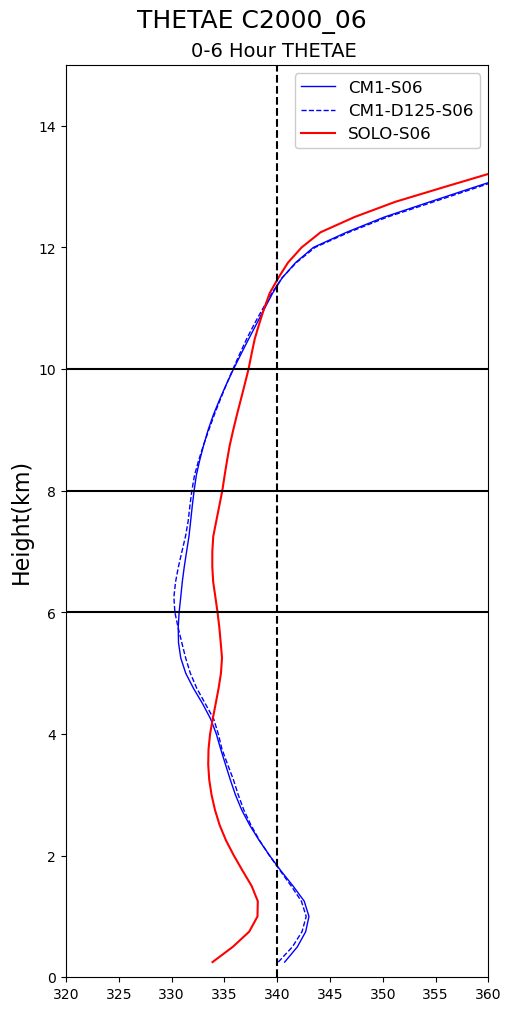

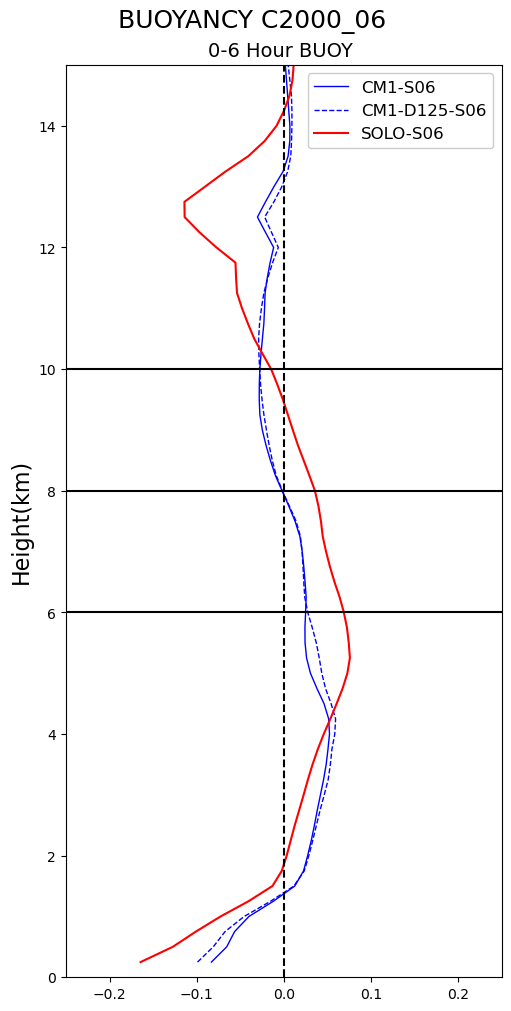

In [268]:
# Set profiles up

models = {}

#models['wrf']   = pickle2Obj('profiles/wrf_squall_3km_dbz99.pkl',retObj=False)
models['cm1']   = pickle2Obj('profiles/cm1_squall_3km_dt10_hdd000_dbz99.pkl',retObj=False)
models['cm1_hdd125']   = pickle2Obj('profiles/cm1_squall_3km_dt10_hdd125_dbz99.pkl',retObj=False)
#models['solo_hdd012'] = pickle2Obj('profiles/solo_squall_3km_dt20_hdd012_dbz99.pkl', retObj=False)
models['solo_hdd125'] = pickle2Obj('profiles/solo_squall_3km_dt20_hdd125_dbz99.pkl', retObj=False)

#plot_distr( models, var='qv', sort=True, xlim=[0.0, 0.02], plabel = 'PERT-THETA', plotcape = ["C2000"], plotshear=["06"])
plot_distr( models, var='thetae', sort=True, xlim=[320., 360.], vline = 340., plabel = 'THETAE', plotcape = ["C2000"], plotshear=["06"]) 
plot_distr( models, var='buoy', sort=True, xlim=[-0.25,0.25], plabel = 'BUOYANCY',plotcape = ["C2000"], plotshear=["06"] )

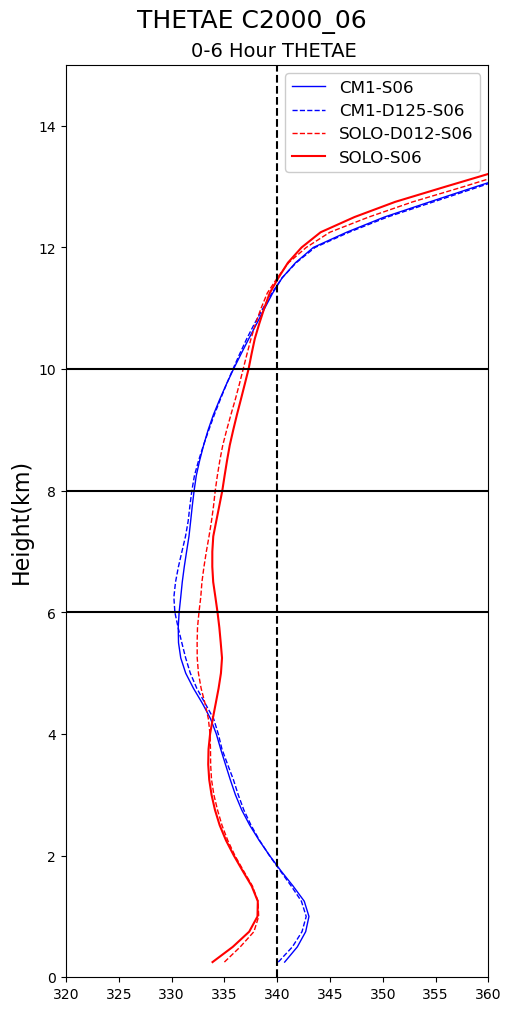

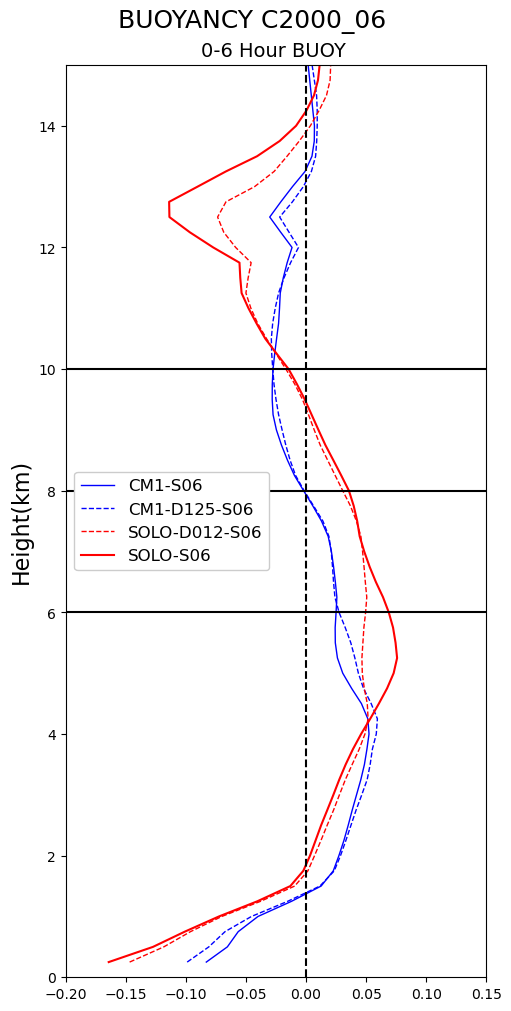

In [254]:
models = {}

#models['wrf']          = pickle2Obj('profiles/wrf_squall_3km_dbz99.pkl',retObj=False)
models['cm1']   = pickle2Obj('profiles/cm1_squall_3km_dt10_hdd000_dbz99.pkl',retObj=False)
models['cm1_hdd125']   = pickle2Obj('profiles/cm1_squall_3km_dt10_hdd125_dbz99.pkl',retObj=False)
models['solo_hdd012'] = pickle2Obj('profiles/solo_squall_3km_dt20_hdd012_dbz99.pkl', retObj=False)
models['solo_hdd125'] = pickle2Obj('profiles/solo_squall_3km_dt20_hdd125_dbz99.pkl', retObj=False)

plot_distr( models, var='thetae', sort=True, xlim=[320., 360.], vline = 340., plabel = 'THETAE', plotcape = ["C2000"], plotshear=["06"]) 
plot_distr( models, var='buoy', sort=True, xlim=[-0.2,0.15], plabel = 'BUOYANCY',plotcape = ["C2000"], plotshear=["06"] )

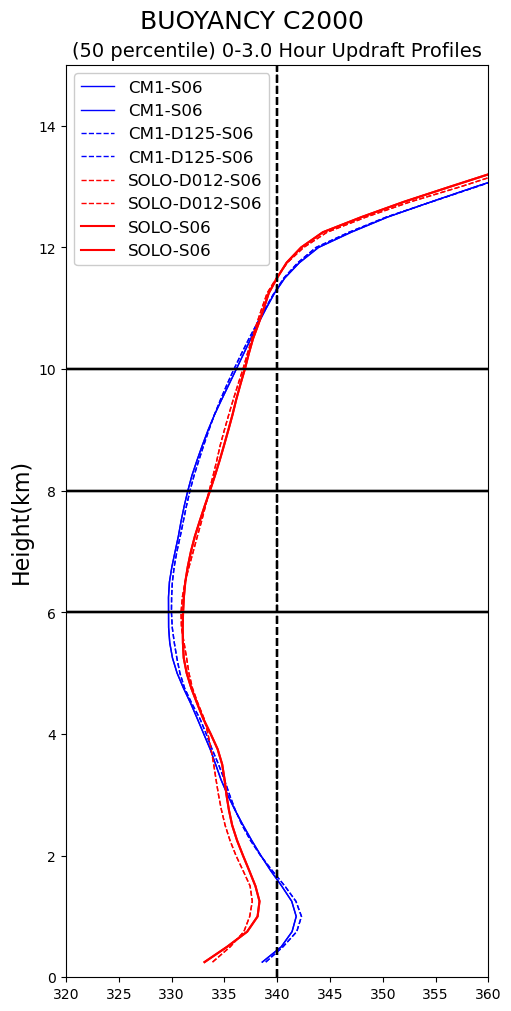

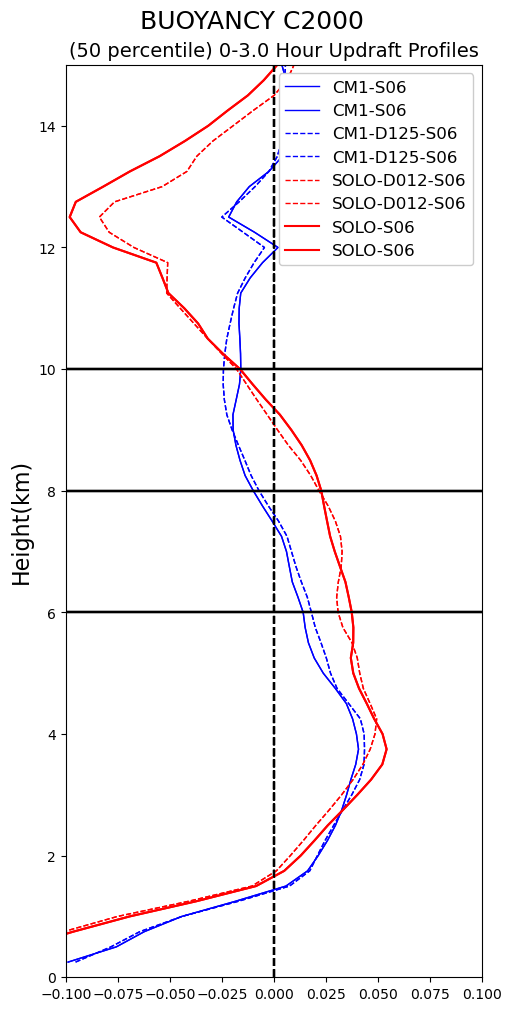

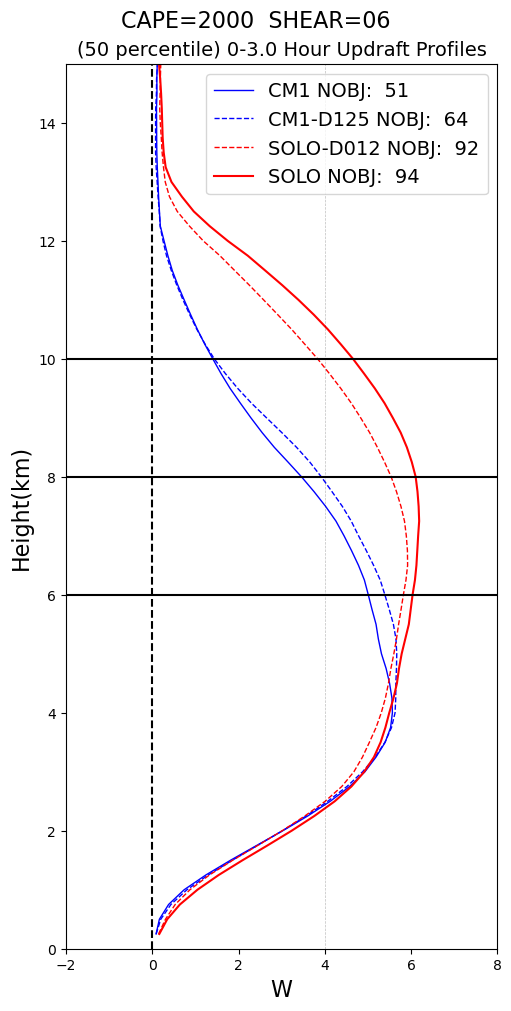

In [272]:
plot_attr   = { 
                "solo":        {"name":"SOLO",       "color": 'r',         'linewidth': 1.0, 'linestyle': 'solid'},
                "solo_hdd012": {"name":"SOLO-D012",  "color": 'r',   'linewidth': 1.0, 'linestyle': '--'},
                "solo_hdd125": {"name":"SOLO",       "color": 'r',         'linewidth': 1.5, 'linestyle': 'solid'},
                "cm1":         {"name":"CM1",        "color": 'b',        'linewidth': 1.0, 'linestyle': 'solid'},
                "cm1_hdd012":  {"name":"CM1-D012",   "color": 'darkblue', 'linewidth': 1.0, 'linestyle': '--'},
                "cm1_hdd125":  {"name":"CM1-D125",   "color": 'b',        'linewidth': 1.0, 'linestyle': '--'},
                "wrf":         {"name":"WRF",        "color": 'k',        'linewidth': 1.0, 'linestyle': 'solid'}
               }

plot_attr['solo_hdd012'] |= {'C2000_18': {"color": 'k', 'linestyle': '--'}, 'C3500_18': {'linestyle': '--'}}
plot_attr["solo_hdd125"] |= {'C2000_18': {"color": 'k', 'linestyle': 'solid'}, 'C3500_18': {'linestyle': 'solid'}}
plot_attr['cm1']         |= {'C2000_18': {'linestyle': 'solid'}, 'C3500_18': {'linestyle': 'solid'}}
plot_attr['wrf']         |= {'C2000_18': {'linestyle': '--'}, 'C3500_18': {'linestyle': '--'}}


# Set profiles up

models = {}

#models['wrf']   = pickle2Obj('profiles/wrf_squall_3km_dbz99.pkl',retObj=False)
models['cm1']   = pickle2Obj('profiles/cm1_squall_3km_dt10_hdd000_dbz99.pkl',retObj=False)
models['cm1_hdd125']   = pickle2Obj('profiles/cm1_squall_3km_dt10_hdd125_dbz99.pkl',retObj=False)
models['solo_hdd012'] = pickle2Obj('profiles/solo_squall_3km_dt20_hdd012_dbz99.pkl', retObj=False)
models['solo_hdd125'] = pickle2Obj('profiles/solo_squall_3km_dt20_hdd125_dbz99.pkl', retObj=False)

#plot_distr( models, var='qv', sort=True, xlim=[0.0, 0.02], plabel = 'PERT-THETA', plotcape = ["C2000"], plotshear=["06"])
#plot_distr( models, var='thetae', sort=True, xlim=[320., 360.], vline = 340., plabel = 'THETAE', plotcape = ["C2000"], plotshear=["06"]) 
plot_distribution( models, var='thetae', percentile=0.5, sort=True, step=[0,12], xlim=[320., 360.], vline = 340., plabel = 'BUOYANCY',plotcape = ["C2000"], plotshear=["06"] )
plot_distribution( models, var='buoy', percentile=0.5, sort=True, step=[0,12], xlim=[-0.1,0.1], plabel = 'BUOYANCY',plotcape = ["C2000"], plotshear=["06"] )
plot_profile_driver(models, plabel = 'Squall_3km', percentile=0.5, step = [0,12], plotcape=["C2000"], plotshear=["06"])

In [181]:
#--------------------------------------------------------------------------------------------
# define w / t / theta plotting

def plot_wptpth_driver(cm1, wrf, fv3, plabel = ""):

    titles = ["Updraft Profiles", "Pert. Temp Profiles", "Pert. Pressure (Pa) Profiles"]

    xvert  = [6.0, 8.0, 12.5]
    xlim   = [8., 15.0, 20.0]

    zhgts = 250. + 250.*np.arange(100)

    allcape = ( "C2000","C3500")
    allshear = ("06", "18")
    
    s = [1,24]
    m = 0

    for cape in allcape:

        label = []

        for shear in allshear:   # create dictionary names

            label.append("%s_%s" % (cape, shear))
        
        fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))
        
        for n, variable in enumerate(['w', 'pert_t', 'pert_p']):
                        
            plot_profile(cm1[label[0]], variable, zhgts, m, ax[n], 'b', 'CM1_06', step=s, linewidth=0.5)
            plot_profile(cm1[label[1]], variable, zhgts, m, ax[n], 'b', 'CM1_12', step=s, linewidth=1.0)
            plot_profile(cm1[label[2]], variable, zhgts, m, ax[n], 'b', 'CM1_18', step=s, linewidth=2.0)

            plot_profile(wrf[label[0]], variable, zhgts, m, ax[n], 'k', 'WRF_06', step=s, linewidth=0.5)
            plot_profile(wrf[label[1]], variable, zhgts, m, ax[n], 'k', 'WRF_12', step=s, linewidth=1.0)
            plot_profile(wrf[label[2]], variable, zhgts, m, ax[n], 'k', 'WRF_18', step=s, linewidth=2.0)
                        
            plot_profile(fv3[label[0]], variable, zhgts, m, ax[n], 'r', 'FV3_06', step=s, linewidth=0.5)
            plot_profile(fv3[label[1]], variable, zhgts, m, ax[n], 'r', 'FV3_12', step=s, linewidth=1.0)
            plot_profile(fv3[label[2]], variable, zhgts, m, ax[n], 'r', 'FV3_18', step=s, linewidth=2.0)

            
            ax[n].set_title("%s" % titles[n], fontsize=18)
                                      
            ax[n].axhline(y=6000., color='k', linestyle='-')
            ax[n].axhline(y=8000., color='k', linestyle='-')
            ax[n].axhline(y=10000., color='k', linestyle='-')
            ax[n].axhline(y=12000., color='k', linestyle='-')

            ax[n].set_ylim(0.0,25000.) 
                                       
            if n == 0:
                ax[n].axvline(x=0.0, color='k', linestyle='--')
                ax[n].axvline(x=xvert[n], color='k', linestyle='--')
                ax[n].legend(fontsize=12, loc='upper right')
                ax[n].set_xlim(-3.0,xlim[n])
               
            elif n == 1:
                ax[n].legend(fontsize=12, loc='upper left')
                ax[n].axvline(x=0.0, color='k', linestyle='--')
                ax[n].set_xlim(-7.,7.0)
            else:
                ax[n].legend(fontsize=12, loc='upper left')
                ax[n].axvline(x=0.0, color='k', linestyle='--')
                ax[n].set_xlim(-800, 400)

        plt.suptitle("%s  CAPE = %s" % (plabel, cape[1:]), fontsize=24)
        plt.show()
        
#######################

#----------------------------------------------------
def plot_var_size(models, xvar = 'object_size', var='w', colors='k', xlim=[0,50], ylim=[0,20], depth=[0,40], 
                   plotcape = ["C2000", "C3500"], plotshear=["06", "18"], max=True, msize=80, alpha=1.0, marker=".", 
                   which_models=None, plabel=""):
    
    titles = ["0-6 Hour Updraft Sizes", "0-2 Hour Updraft Sizes", "2-4 Hour Updraft Sizes"]

    allcape = ("C2000", "C3500")
    allshear = ("06", "18")
    
    max_pix = xlim[1]
    
    if which_models == None:
        which_models = models
    
    for cape in plotcape:

        for shear in plotshear:   # create dictionary names
            
            label = "%s_%s" % (cape, shear)
            
            fig, ax = plt.subplots(1,2, constrained_layout=True,figsize=(14,7))
            
            for n, key in enumerate(which_models):
                
                mdata = models[key]
                
                t0 = mdata[label]['tindex'][0]
                t1 = mdata[label]['tindex'][20]

                if xvar == 'size':
                    size = mdata[label]['size'][t0:t1]
                else:
                    size = mdata[label][xvar][depth[0]:depth[1],t0:t1].mean(axis=0)
                    
                if max:
                    w    = mdata[label][var][depth[0]:depth[1],t0:t1].max(axis=0)
                else:
                    w    = mdata[label][var][depth[0]:depth[1],t0:t1].mean(axis=0)
                      
                if key == 'solo_hdd012':

                    if xvar == 'size':
                        ax[1].scatter(size[size<max_pix], w[size<max_pix],   s=msize, c='darkred', marker=marker, alpha=alpha, linewidths=0.25)
                        ax[1].set_title("%s: # Pts: %3.0d \n Mean Size: %3.1f   MEAN of FLD:  %5.2f" % \
                                    ('SOLO-D012', len(size<max_pix), np.mean(size[size<max_pix]), np.mean(w[size<max_pix])), fontsize=20)
                    else:
                        ax[1].scatter(size, w,   s=msize, c='darkred', marker=marker, alpha=alpha, linewidths=0.25)
                        ax[1].set_title("%s: MEAN of %s:  %5.2f" % ('SOLO-D012', var, np.mean(w)), fontsize=20)

                if key == 'solo_hdd125':

                    if xvar == 'size':
                        ax[1].scatter(size[size<max_pix], w[size<max_pix],   s=msize, c='r', marker=marker, alpha=alpha, linewidths=0.25)
                        ax[1].set_title("%s: # Pts: %3.0d \n Mean Size: %3.1f   MEAN of FLD:  %5.2f" % \
                                    ('SOLO-D125', len(size<max_pix), np.mean(size[size<max_pix]), np.mean(w[size<max_pix])), fontsize=20)
                    else:
                        ax[1].scatter(size, w,   s=msize, c='r', marker=marker, alpha=alpha, linewidths=0.25)
                        ax[1].set_title("%s: MEAN of %s:  %5.2f" % ('SOLO-D125', var, np.mean(w)), fontsize=20)

                        
                if key == 'cm1_hdd012':
                    if xvar == 'size':
                        ax[0].scatter(size[size<max_pix], w[size<max_pix],   s=msize, c='b', marker=marker, alpha=alpha, linewidths=0.25)
                        ax[0].set_title("%s: # Pts: %3.0d \n Mean Size: %3.1f   MEAN of FLD:  %5.3f" % \
                                    ('CM1-D012', len(size<max_pix), np.mean(size[size<max_pix]), np.mean(w[size<max_pix])), fontsize=20)
                    else:
                        ax[0].scatter(size, w,   s=msize, c='b', marker=marker, alpha=alpha, linewidths=0.25)
                        ax[0].set_title("%s: MEAN of %s:  %5.2f" % ('CM1-D012', var, np.mean(w)), fontsize=20)
                        
                if key == 'cm1_hdd125':
                    if xvar == 'size':
                        ax[0].scatter(size[size<max_pix], w[size<max_pix],   s=msize, c='darkblue', marker=marker, alpha=alpha, linewidths=0.25)
                        ax[0].set_title("%s: # Pts: %3.0d \n Mean Size: %3.1f   MEAN of FLD:  %5.3f" % \
                                    ('CM1-D125', len(size<max_pix), np.mean(size[size<max_pix]), np.mean(w[size<max_pix])), fontsize=20)
                    else:
                        ax[0].scatter(size, w,   s=msize, c='darkblue', marker=marker, alpha=alpha, linewidths=0.25)
                        ax[0].set_title("%s: MEAN of %s:  %5.2f" % ('CM1-D125', var, np.mean(w)), fontsize=20)


#                 if key == 'wrf':
#                     if xvar == 'size':
#                         ax[0].scatter(size[size<max_pix], w[size<max_pix],   s=msize, c='k', marker=marker, alpha=alpha, linewidths=0.25)
#                         ax[0].set_title("%s: \n Mean Size: %3.1f  MEAN of FLD:  %5.3f" % \
#                                      ('WRF', np.mean(size[size<max_pix]), np.mean(w[size<max_pix])), fontsize=20)
#                     else:
#                         ax[0].scatter(size, w,   s=msize, c='k', marker=marker, alpha=alpha, linewidths=0.25)
#                         ax[0].set_title("%s: MEAN of %s:  %5.2f" % ('WRF', var, np.mean(w)), fontsize=20)

#                 if key == 'mpas':
#                     if xvar == 'size':
#                         ax[1].scatter(size[size<max_pix], w[size<max_pix],   s=msize, c='g', marker=marker, alpha=alpha, linewidths=0.25)
#                         ax[1].set_title("%s: # Pts: %3.0d \n Mean Size: %3.1f MEAN of FLD:  %5.3f" % \
#                                     ('MPAS', len(size<max_pix), np.mean(size[size<max_pix]), np.mean(w[size<max_pix])), fontsize=20)

#                     else:
#                         ax[1].scatter(size, w,   s=msize, c='g', marker=marker, alpha=alpha, linewidths=0.25)
#                         ax[1].set_title("%s: MEAN of %s:  %5.2f" % ('MPAS', var, np.mean(w)), fontsize=20)

                ax[0].set_xlim(xlim)
                ax[0].set_ylim(ylim[:])
                ax[0].set_xlabel("%s" % xvar.upper(), fontsize=14)
                ax[0].set_ylabel(var.upper() , fontsize=14)
                
                ax[1].set_xlim(xlim)
                ax[1].set_ylim(ylim[:])
                ax[1].set_xlabel("%s" % xvar.upper(), fontsize=14)
                ax[1].set_ylabel(var.upper() , fontsize=14)

            
            plt.suptitle("Experiment %s %s" % (plabel, label), fontsize=24)
            plt.savefig("Pixel_%s_2D_%s.png" % (var.upper(), label))

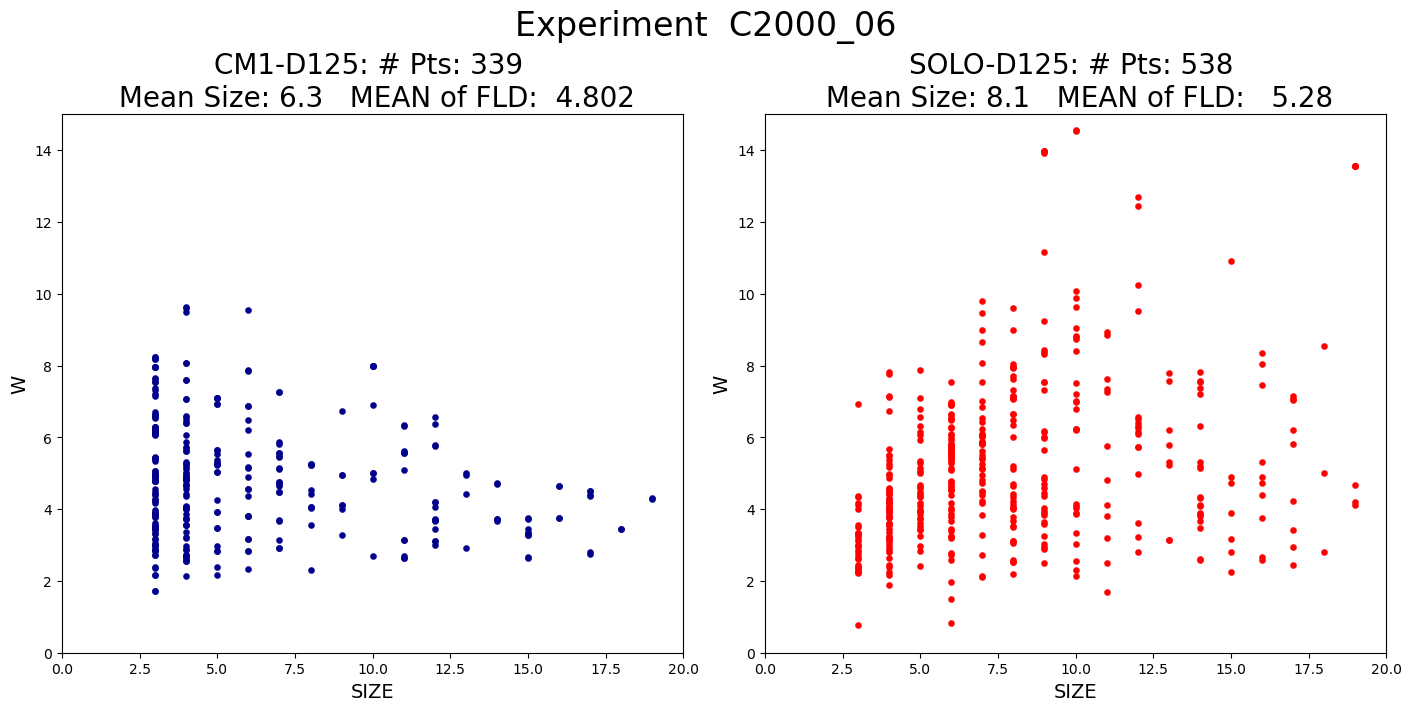

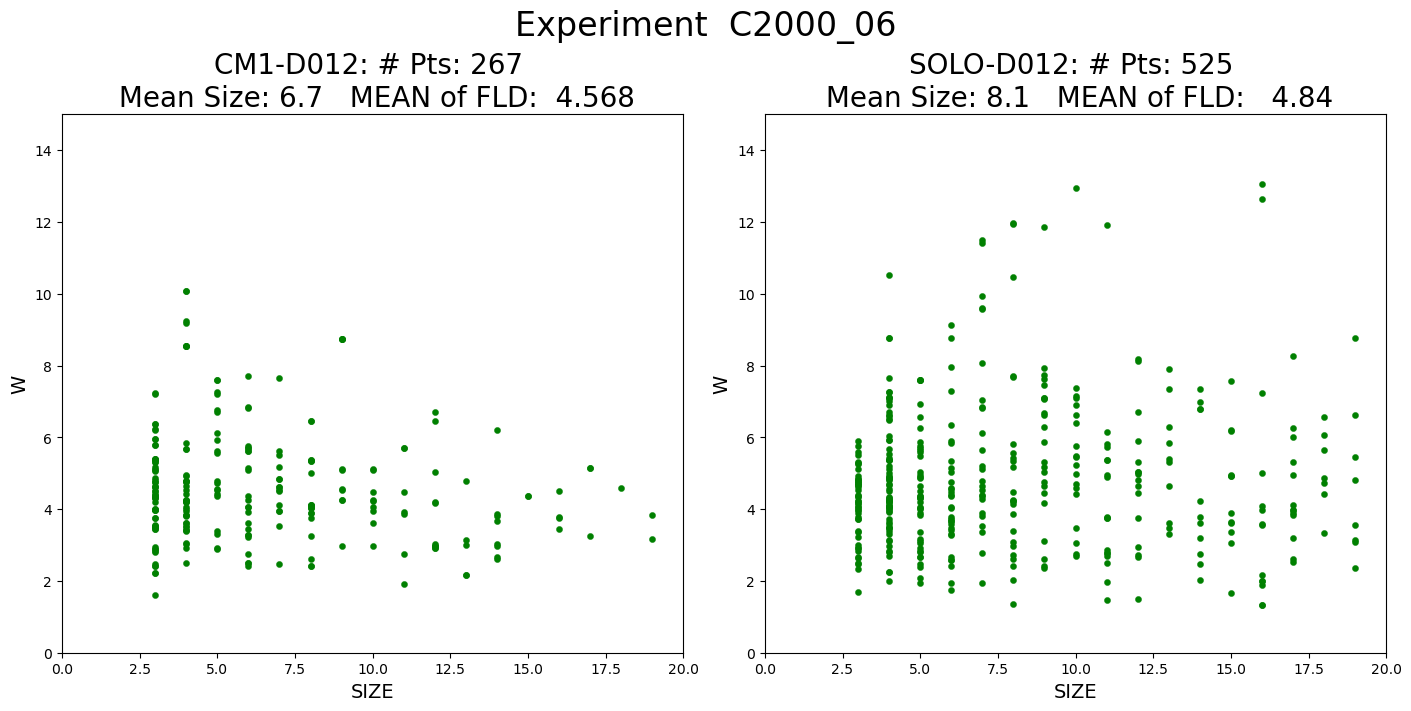

In [184]:


#check_data(models)

# plot_var_size(models, var='thetae', max_pix=50, depth=[0,40], xlim=[320,340], max=False)

plot_var_size(models, xvar='size', var='w', depth=[0,40], xlim=[0,20], ylim=[0,15], msize=80, plotcape=["C2000"], plotshear=["06"], which_models=["cm1_hdd125", "solo_hdd125"], max=True)
plot_var_size(models, xvar='size', var='w', depth=[0,40], xlim=[0,20], ylim=[0,15], msize=80, plotcape=["C2000"], plotshear=["06"], which_models=["cm1_hdd012", "solo_hdd012"], max=True)

# plot_var_size(models, var='buoy', depth=[0,40], ylim=[-0.1,0.1], msize=80, max=False)
#plot_var_size(models, var='buoy', depth=[0,40], ylim=[0.,0.15], plotcape=["C2000"], plotshear=["06"], max=True)
# plot_var_size(models, max_pix=50, depth=[0,40], ylim=[0,20], max=False)

In [51]:
#----------------------------------------------------
def mk_boxplot(models, var='w', colors='k', max_pix=100, ylim=[0,20], depth=[0,40], max=True, msize=80, alpha=1.0, marker=".", plabel="", **kwargs):
    
    titles = ["0-6 Hour Updraft Sizes", "0-2 Hour Updraft Sizes", "2-4 Hour Updraft Sizes"]

    allcape = ("C2000", "C3500")
    allshear = ("06", "18")
    
    for cape in allcape:

        for shear in allshear:   # create dictionary names
            
            label = "%s_%s" % (cape, shear)
            
            fig, ax = plt.subplots(1,4, constrained_layout=True,figsize=(16,7))
            
            for n, key in enumerate(models):
                
                mdata = models[key]
                
                t0 = mdata[label]['tindex'][0]
                t1 = mdata[label]['tindex'][20]

                size = mdata[label]['size'][t0:t1]
                if max:
                    w    = mdata[label][var][depth[0]:depth[1],t0:t1].max(axis=0)
                else:
                    w    = mdata[label][var][depth[0]:depth[1],t0:t1].mean(axis=0)

                if key == 'solo':

                    ax[3].violinplot(w[size<max_pix], **kwargs)
                    ax[3].set_title("%s: # Pts: %3.0d \n MEAN of %s:  %5.2f" % \
                                   ('FV3-SOLO', len(size<max_pix), var.upper(), np.mean(w[size<max_pix])), fontsize=14)

                if key == 'cm1':
                    ax[2].violinplot(w[size<max_pix], **kwargs)
                    ax[2].set_title("%s: # Pts: %3.0d \n MEAN of %s:  %5.3f" % \
                                    ('CM1', len(size<max_pix), var.upper(), np.mean(w[size<max_pix])), fontsize=14)

                if key == 'wrf':
                    ax[0].violinplot(w[size<max_pix], **kwargs)
                    ax[0].set_title("%s: # Pts: %3.0d \n MEAN of %s:  %5.3f" % \
                                    ('WRF', len(size<max_pix), var.upper(), np.mean(w[size<max_pix])), fontsize=14)

                if key == 'mpas':
                    ax[1].violinplot(w[size<max_pix], **kwargs)
                    ax[1].set_title("%s: # Pts: %3.0d \n MEAN of %s:  %5.3f" % \
                                    ('MPAS', len(size<max_pix), var.upper(), np.mean(w[size<max_pix])), fontsize=14)

#                     ax[n].set_title("%s - (Updraft Size in Pixels)" % (titles[n]))
                # ax[n].axhline(0.5*(ylim[0]+ylim[1]), color='k', linestyle='--', alpha=0.25)
#                     ax[n].axhline(y=0.9,  color='k', linestyle='--')

                # ax[n].set_xlim(0,max_pix)
                ax[n].set_ylim(ylim[:])
                # ax[n].set_xlabel("Size (pix)", fontsize=14)
                # ax[n].set_ylabel(var.upper() , fontsize=14)
            
            plt.suptitle("Experiment %s %s" % (plabel, label), fontsize=24)
            plt.savefig("BoxPlot_%s_2D_%s.png" % (var.upper(), label))

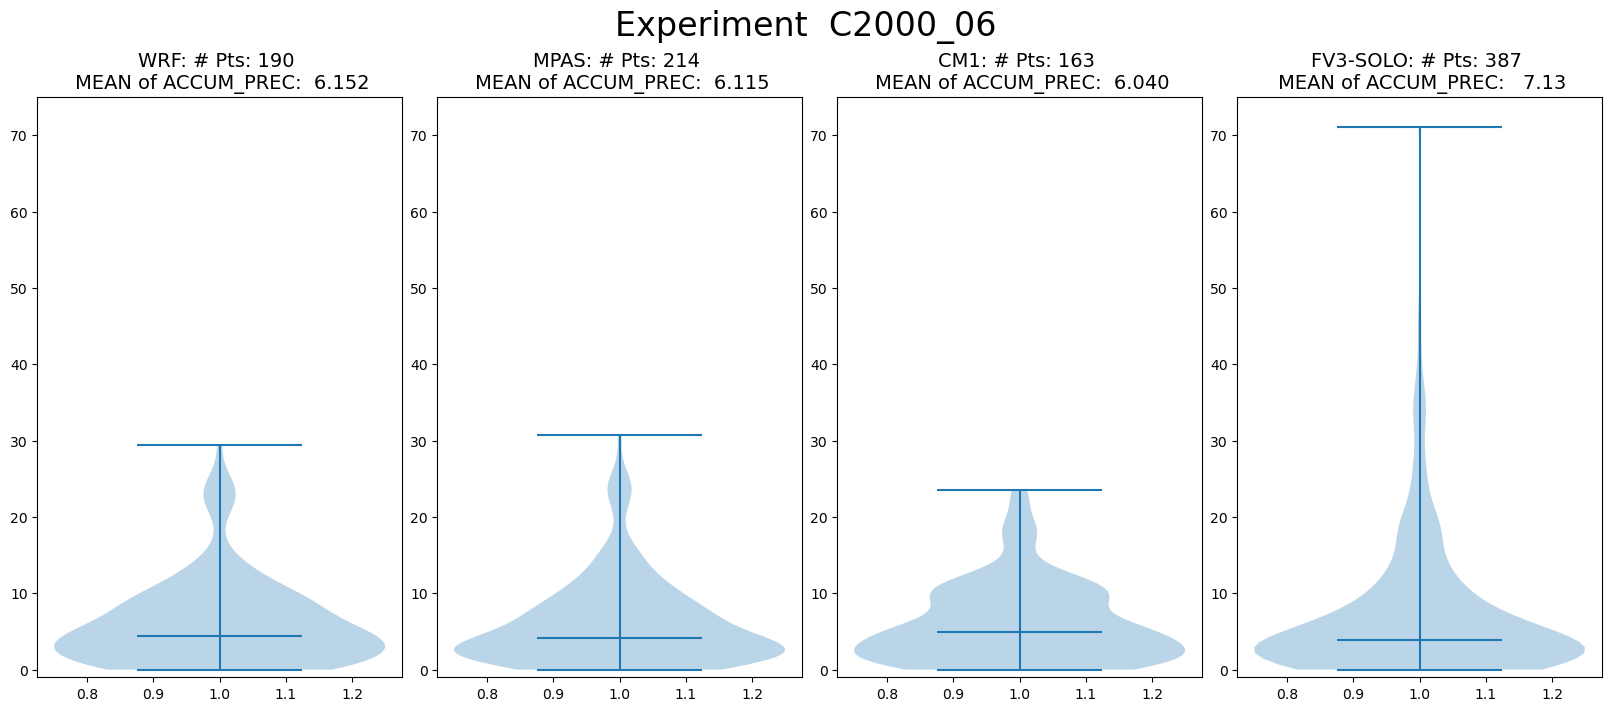

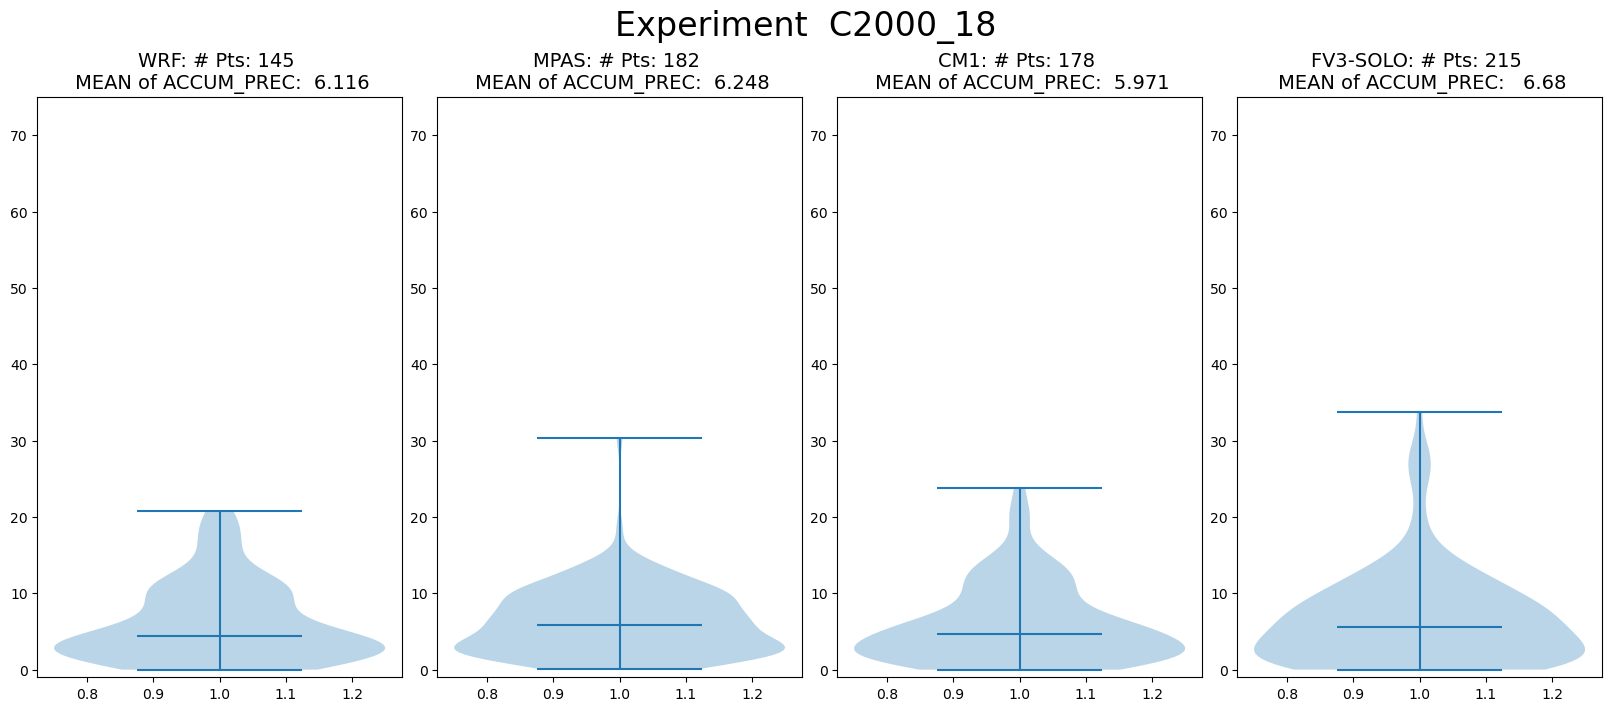

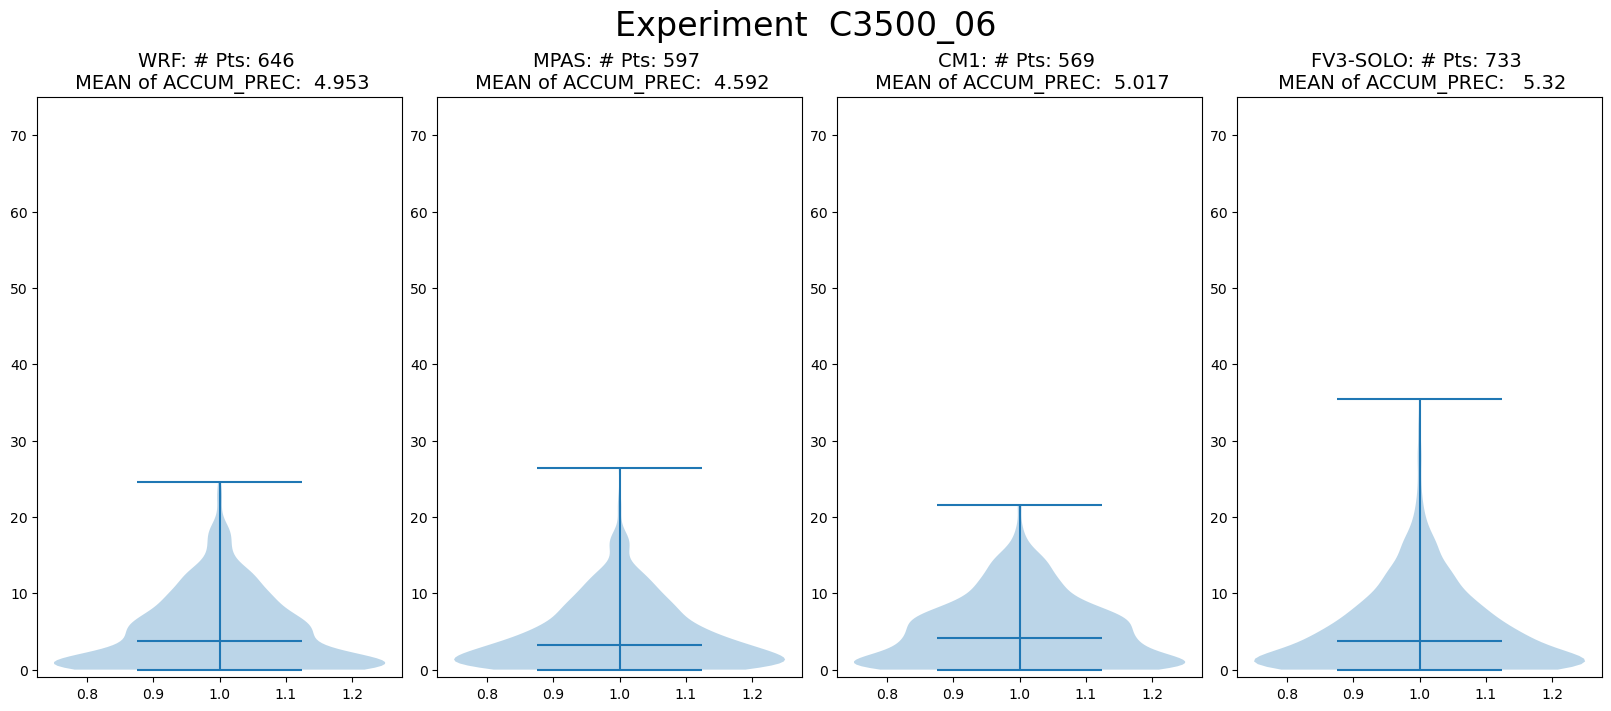

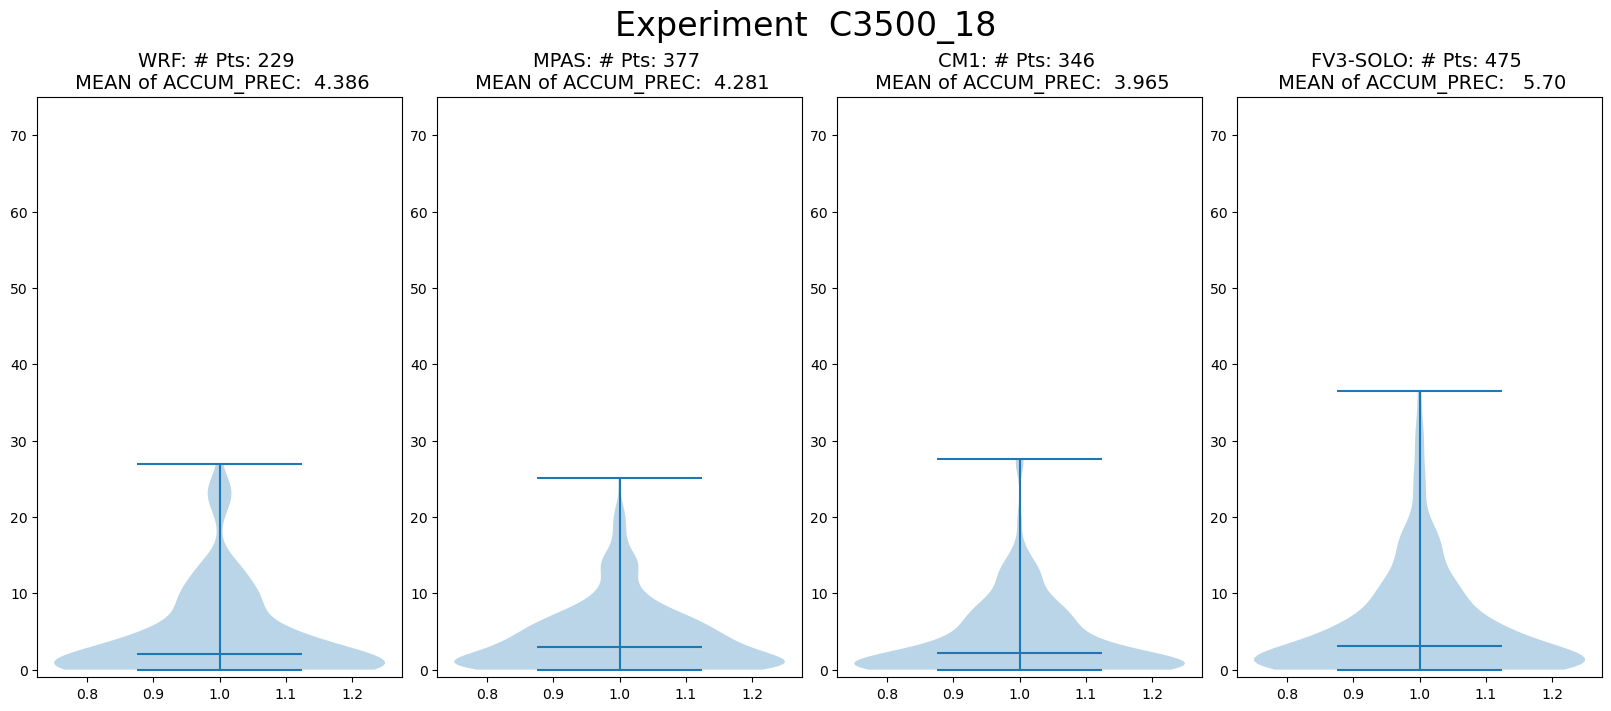

In [53]:
#mk_boxplot(models, var='buoy', max_pix=50, depth=[0,40], ylim=[-0.1,0.1], msize=80, max=False)
mk_boxplot(models, var='accum_prec', max_pix=50, depth=[0,40], ylim=[-1,75], max=False, showmedians=False)
#mk_boxplot(models, max_pix=50, depth=[0,40], ylim=[0,12], max=False)

In [113]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
ds = xa.open_dataset("/work/wicker/Odin_scr/solo/squall_3km_C2000_06/atmos_hifreq.nc", decode_times=False)
# print(ds)

t=20
ds_small=ds.isel(time=t,grid_xt=slice(64,192),grid_yt=slice(64,192))
ds_ref=ds.isel(time=0,grid_xt=0,grid_yt=0)
print(ds_ref['pfull'])

<xarray.DataArray 'pfull' (pfull: 60)>
array([ 43.614677,  50.58378 ,  57.112206,  63.821526,  70.811905,  78.27187 ,
        86.26582 ,  94.8073  , 103.90844 , 113.57964 , 123.82971 , 134.66559 ,
       146.09221 , 158.11314 , 170.72945 , 183.94095 , 197.74487 , 212.13754 ,
       227.1126  , 242.66206 , 258.7766  , 275.44495 , 292.65454 , 310.39114 ,
       328.63913 , 347.38123 , 366.59967 , 386.2756  , 406.3879  , 426.91577 ,
       447.83743 , 469.13055 , 490.77145 , 512.73615 , 535.0022  , 557.545   ,
       580.33923 , 603.3609  , 626.5848  , 649.9866  , 673.54346 , 697.23157 ,
       721.0274  , 744.94727 , 768.9717  , 792.7775  , 815.9177  , 838.1427  ,
       859.33813 , 879.40344 , 898.22766 , 915.7209  , 931.7789  , 946.3301  ,
       959.2798  , 970.566   , 980.1263  , 987.9095  , 994.0884  , 998.4039  ],
      dtype=float32)
Coordinates:
    grid_xt  float32 1.0
    grid_yt  float32 1.0
    time     float32 900.0
  * pfull    (pfull) float32 43.61 50.58 57.11 63.82 ... 98

In [124]:
phalf = ds_small.phalf

ptop  = 100*phalf[0]
phalf = 100*phalf[1:]
phyd  = ds_small.delp.sum(dim="pfull") + ptop

phyd_ref   = ds_ref.delp.sum(dim="pfull") + ptop
psphum     = ((ds_small.spfh)*ds_small.delp).sum(dim="pfull")
psphum_ref = ((ds_ref.spfh)*ds_ref.delp).sum(dim="pfull")

#qp and qn are **weight** per grid cell and not specific ratios
pcond=((ds_small.qp + ds_small.qn)).sum(dim="pfull")

#print(phyd_ref)
print(ds_small.nhpres_pert)

<xarray.DataArray 'nhpres_pert' (pfull: 60, grid_yt: 128, grid_xt: 128)>
array([[[ 3.320312e-02,  5.322266e-02, ...,  5.175781e-02,  3.369141e-02],
        [ 7.812500e-03,  5.859375e-03, ...,  2.783203e-02,  1.708984e-02],
        ...,
        [ 9.765625e-03,  3.466797e-02, ...,  2.246094e-02,  5.761719e-02],
        [ 3.808594e-02,  3.369141e-02, ...,  4.101562e-02,  3.710938e-02]],

       [[ 3.662109e-02,  1.074219e-02, ...,  3.466797e-02,  3.369141e-02],
        [ 3.417969e-02,  7.080078e-02, ...,  2.587891e-02,  3.710938e-02],
        ...,
        [ 2.783203e-02,  2.441406e-02, ...,  4.882812e-02, -5.371094e-03],
        [ 8.300781e-03,  2.246094e-02, ...,  4.296875e-02,  1.220703e-02]],

       ...,

       [[ 9.671875e+00,  1.132031e+01, ..., -2.550781e+01,  1.000000e+01],
        [ 1.359375e+00, -1.075781e+01, ..., -8.742188e+00, -7.125000e+00],
        ...,
        [ 9.632812e+00, -2.117188e+00, ...,  8.820312e+00,  9.578125e+00],
        [ 2.054688e+00,  2.335938e+00, ..., -8

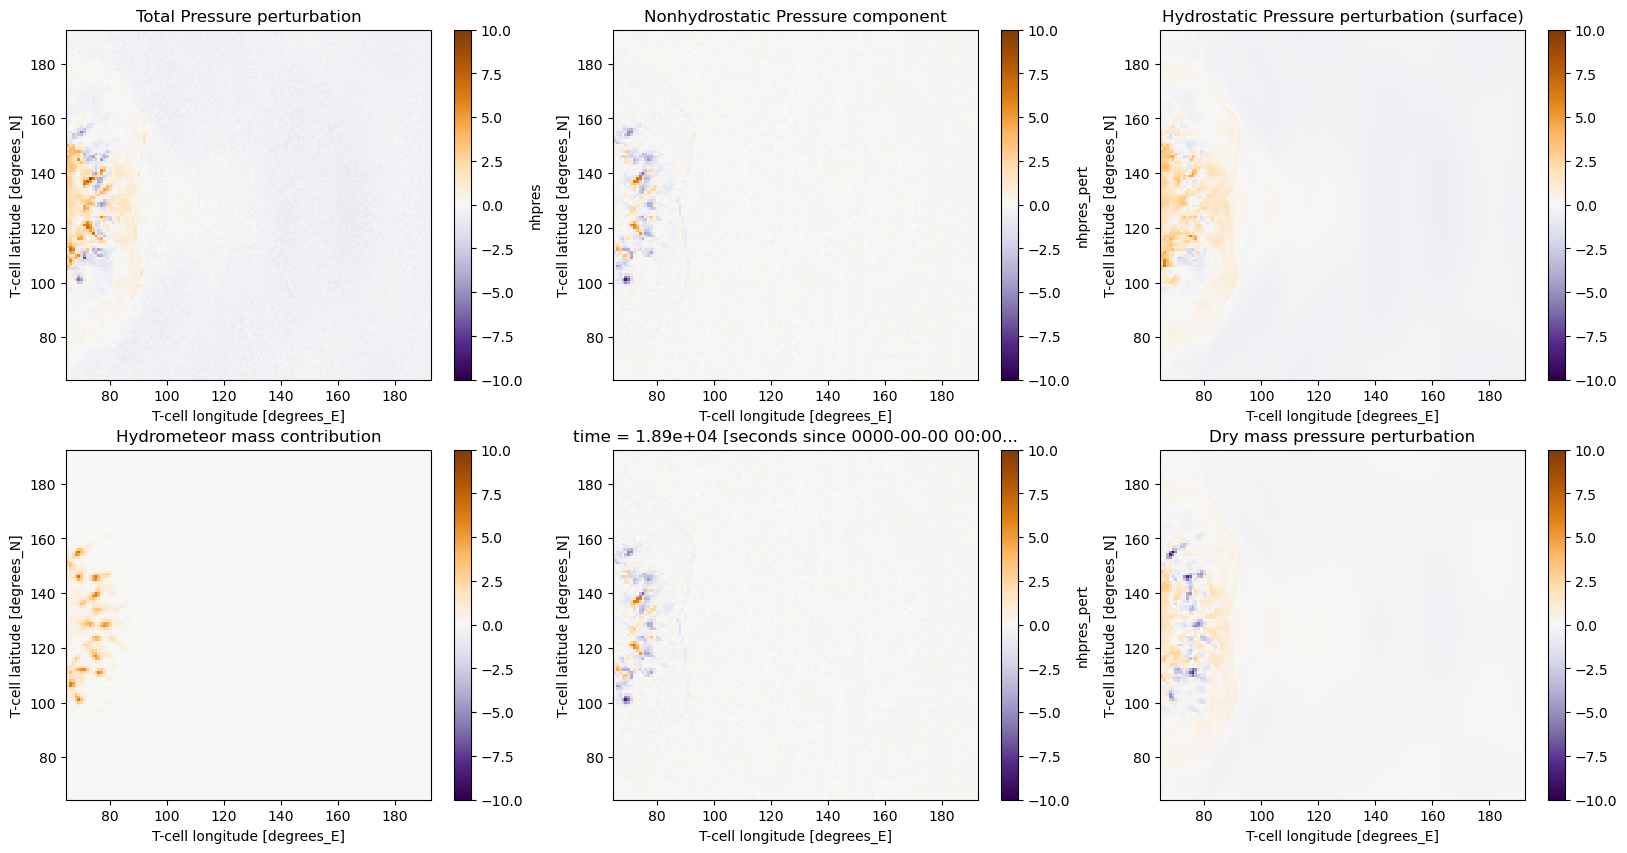

In [127]:
fig = plt.figure(figsize=(20,10))

#nhpres anom
ax = fig.add_subplot(2,3,1)
((ds_small.nhpres[-1,:,:]-ds_ref.nhpres[-1])/100.).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax.set_title("Total Pressure perturbation")

# nhpres_pert
ax = fig.add_subplot(2,3,2)
((ds_small.nhpres_pert[-1,:,:])/100.).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax.set_title("Nonhydrostatic Pressure component")

ax = fig.add_subplot(2,3,3)
((phyd-phyd_ref)/100.).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax.set_title("Hydrostatic Pressure perturbation (surface)")

# #hydrometeors
ax = fig.add_subplot(2,3,4)
(pcond/100.).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
ax.set_title("Hydrometeor mass contribution")

#dry pressure perturbation
ax = fig.add_subplot(2,3,5)
((ds_small.nhpres_pert[-1]/100.).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r')))
ax.set_title("Dry mass pressure perturbation");
#((psphum)/100.).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))
#ax.set_title("Water vapor mass contribution");

#dry pressure perturbation
ax = fig.add_subplot(2,3,6)
((phyd-(phyd_ref-psphum_ref)-pcond-psphum)/100.).plot(ax=ax,vmax=10,vmin=-10,cmap=plt.get_cmap('PuOr_r'))

ax.set_title("Dry mass pressure perturbation");

# #Add location of cross section
# #NOTE: apparently this behavior will change in a future version of Matplotlib
# #  so if it makes empty plots then just remove it.
# ycross=44
# for n in range(6):
#     ax = fig.add_subplot(2,3,n+1)
#     ax.set_xlabel("")
#     ax.plot(ax.get_xlim(),[ycross,ycross],color='k',linewidth=5,alpha=0.5)